In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
from pyalgotrade import dataseries
from pyalgotrade.dataseries import aligned
from pyalgotrade.optimizer import local
import statsmodels.api as sm

import itertools
from IPython.core.interactiveshell import InteractiveShell
from pymermaid import MermaidMarkdown
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(18,10)

<div class="jumbotron">
    <p class="display-1 h1">量化交易模型评估</p>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

<center><img src="./img/performance/performanceFramework.png" width=100%></center>

# 评估指标

##### 总盈利率

$$
    \text{总盈利率}=\frac{\text{期末权益}-\text{期初权益}}{\text{期初权益}}
$$

##### 当日收益率

$$
    \text{当日收益率}=\frac{\text{当日权益}+\text{当日出金}}{\text{昨日权益}+\text{昨日入金}}-1
$$

##### 当日净值

$$
    \text{当日净值}=1+\text{当日收益率}
$$

##### 累计净值

$$
    P=\Pi_{i=1}^n P_i
$$

- $P_i$为第$i$天的当日净值

##### 最大回撤

- 回撤(drawdown)：一个净值高点与下一个净值高点之间出现的最低点与高点之间的回落百分比

<center><img src="./img/performance/drawdown.png" width=100%></center>

$$
    \text{历史最大回撤率}=\max\{\frac{\text{历史最大累计净值}-\text{当日累计净值}}{\text{历史最大累计净值}}\}
$$

##### 夏普比率

$$
    \text{sharpe ratio}=\frac{E(r_p）-r_f}{\sigma_p}
$$

- $r_f$：无风险收益率
- $r_p$：投资组合的收益率
- $\sigma_p$：投资组合收益的标准差

##### 信息比率

$$
    \text{information ratio} = \frac{E(r)-E(r_B)}{\sigma_{r-r_B}}
$$

- $r_B$：基准投资组合收益率
- $\sigma_{r-r_B}$：当前投资组合与基准投资组合收益率差的标准差

#####  索提诺比率（Sortino ratio） 

- 关注收益率下行风险

- 选取最小可接受收益率（minimum acceptable return, MAR）

$$
\text{sortino ratio}=\frac{r_p-\text{MAR}}{\sqrt{\frac{1}{T}\sum_{t=0}^T(r_{pt}-\text{MAR})^2}}
$$

- $r_{pt}$为第$t$周期的收益率，满足$r_{pt}<\text{MAR}$

##### 詹森指数

- 詹森指数（Jensen）$\alpha_p$

$$
\alpha_p=r_p-\left[r_f+\beta(r_m-r_f)\right]
$$

- $\alpha_p>0$：投资组合的绩效优于市场

- $\alpha_p<0$：投资组合的绩效差于市场

# 样本内绩效

## 样本内数据

- 真实交易的历史数据

- 生成的模拟交易数据

- 基本面数据

## 回测框架

<center><img src="./img/performance/backtestFramework.png" width=100%></center>

### 事件驱动（event-driven）的回测框架

- 一个时间循环，依据市场当时的情况发出交易信号

- 优点
    - 更加趋于真实交易的回测，代码经过简单修正可以用于实盘交易
    - 灵活，可以回测复杂的交易逻辑
    - 可以避免**前瞻性偏差（lookahead bias）**

- 缺点
    - 代码量大
    - 回测速度慢

### 向量化（vectorized）回测框架

- 获取交易策略所需要的所有数据与指标，将其转换成向量，利用线性代数的方法回测

- 优势
    - 代码量小
    - 回测速度快

- 缺点
    - 不灵活
    - 易于出现前瞻性偏差

#### 前瞻性偏差

##### 例1

```python
if close_t>open_t:
    Order(price=low_t,volume=1,direction='long')
```

##### 例2 

- 根据企业的季度财务报表公布的业绩情况决定股票的购买或平仓

- 在2020年12月31日根据某企业发布的第四季度的财报做出建仓决策

### 当前主要的回测框架

##### `PyAlgoTrade`

- 事件驱动的回测框架
- 支持比特币的实盘交易
- 集成`TA-Lib`
- [http://gbeced.github.io/pyalgotrade/](http://gbeced.github.io/pyalgotrade/)

##### `Zipline`

- 事件驱动的回测框架
- Quantopian基于该框架开发了云计算支持的回测
- 用户规模大
- [https://www.zipline.io](https://www.zipline.io)

##### `Backtrader`

- 事件驱动型和向量型回测框架
- 支持实盘交易（国外）
- [https://www.backtrader.com](https://www.backtrader.com)

##### `backtesting.py`

- 事件驱动型回测框架
- 交互式图表
- [https://github.com/kernc/backtesting.py](https://github.com/kernc/backtesting.py)

##### `Vn.py`

- 事件驱动型回测框架
- 支持`CTP`实盘交易
- 国内开发的回测框架
- [https://www.vnpy.com](https://www.vnpy.com)

## `PyAlgoTrade`

- 中文文档 [https://pyalgotrade-docs-zh-cn.readthedocs.io/zh_CN/latest/tutorial.html](https://pyalgotrade-docs-zh-cn.readthedocs.io/zh_CN/latest/tutorial.html)

- 特点
    - 事件驱动型
    - 支持**市价(market)**、**限价(limit)**、**止损(stop)**等交易指令
    - 支持`csv`格式存储的时间序列数据
    - 集成`TA-Lib`
    - 支持`Bitcoin`交易
    - 支持实时`Twitter`事件分析

- 安装

```python
pip install pyalgotrade
```

cross_above shares, 8
cross_below 3424.0 3424.0 2019-12-05 14:44:00
length 30 3424.0
onExitOk 0
cross_above shares, 8
cross_below 3407.0 3407.0 2019-12-05 21:35:00
length 83 3407.0
onExitOk 0
cross_above shares, 8
cross_below 3407.0 3407.0 2019-12-05 21:39:00
length 87 3407.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2019-12-05 21:54:00
length 102 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2019-12-05 22:01:00
length 109 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3403.0 3403.0 2019-12-05 22:17:00
length 125 3403.0
onExitOk 0
cross_above shares, 8
cross_below 3405.0 3405.0 2019-12-05 22:23:00
length 131 3405.0
onExitOk 0
cross_above shares, 8
cross_below 3403.0 3403.0 2019-12-05 22:27:00
length 135 3403.0
onExitOk 0
cross_above shares, 8
cross_below 3405.0 3405.0 2019-12-06 09:10:00
length 179 3405.0
onExitOk 0
cross_above shares, 8
cross_below 3406.0 3406.0 2019-12-06 09:12:00
length 181 3406.0
onExitOk 0
cross_above shares, 8
cross_below

cross_below 3524.0 3524.0 2019-12-12 21:40:00
length 1024 3524.0
onExitOk 0
cross_above shares, 8
cross_below 3525.0 3525.0 2019-12-12 22:00:00
length 1024 3525.0
onExitOk 0
cross_above shares, 8
cross_below 3523.0 3523.0 2019-12-12 22:20:00
length 1024 3523.0
onExitOk 0
cross_above shares, 8
cross_below 3523.0 3523.0 2019-12-12 22:22:00
length 1024 3523.0
onExitOk 0
cross_above shares, 8
cross_below 3522.0 3522.0 2019-12-12 22:28:00
length 1024 3522.0
onExitOk 0
cross_above shares, 8
cross_below 3531.0 3531.0 2019-12-12 22:51:00
length 1024 3531.0
onExitOk 0
cross_above shares, 8
cross_below 3538.0 3538.0 2019-12-13 09:09:00
length 1024 3538.0
onExitOk 0
cross_above shares, 8
cross_below 3536.0 3536.0 2019-12-13 09:29:00
length 1024 3536.0
onExitOk 0
cross_above shares, 8
cross_below 3526.0 3526.0 2019-12-13 09:58:00
length 1024 3526.0
onExitOk 0
cross_above shares, 8
cross_below 3526.0 3526.0 2019-12-13 10:01:00
length 1024 3526.0
onExitOk 0
cross_above shares, 8
cross_below 3526.0 3

cross_below 3491.0 3491.0 2019-12-19 11:03:00
length 1024 3491.0
onExitOk 0
cross_above shares, 8
cross_below 3493.0 3493.0 2019-12-19 11:20:00
length 1024 3493.0
onExitOk 0
cross_above shares, 8
cross_below 3493.0 3493.0 2019-12-19 11:22:00
length 1024 3493.0
onExitOk 0
cross_above shares, 8
cross_below 3516.0 3516.0 2019-12-19 14:01:00
length 1024 3516.0
onExitOk 0
cross_above shares, 8
cross_below 3518.0 3518.0 2019-12-19 14:17:00
length 1024 3518.0
onExitOk 0
cross_above shares, 8
cross_below 3519.0 3519.0 2019-12-19 14:25:00
length 1024 3519.0
onExitOk 0
cross_above shares, 8
cross_below 3518.0 3518.0 2019-12-19 14:31:00
length 1024 3518.0
onExitOk 0
cross_above shares, 8
cross_below 3516.0 3516.0 2019-12-19 14:46:00
length 1024 3516.0
onExitOk 0
cross_above shares, 8
cross_below 3513.0 3513.0 2019-12-19 21:00:00
length 1024 3513.0
onExitOk 0
cross_above shares, 8
cross_below 3511.0 3511.0 2019-12-19 21:47:00
length 1024 3511.0
onExitOk 0
cross_above shares, 8
cross_below 3512.0 3

cross_below 3487.0 3487.0 2019-12-26 10:03:00
length 1024 3487.0
onExitOk 0
cross_above shares, 8
cross_below 3488.0 3488.0 2019-12-26 10:06:00
length 1024 3488.0
onExitOk 0
cross_above shares, 8
cross_below 3492.0 3492.0 2019-12-26 10:34:00
length 1024 3492.0
onExitOk 0
cross_above shares, 8
cross_below 3493.0 3493.0 2019-12-26 10:39:00
length 1024 3493.0
onExitOk 0
cross_above shares, 8
cross_below 3501.0 3501.0 2019-12-26 10:56:00
length 1024 3501.0
onExitOk 0
cross_above shares, 8
cross_below 3503.0 3503.0 2019-12-26 11:01:00
length 1024 3503.0
onExitOk 0
cross_above shares, 8
cross_below 3503.0 3503.0 2019-12-26 11:12:00
length 1024 3503.0
onExitOk 0
cross_above shares, 8
cross_below 3514.0 3514.0 2019-12-26 13:38:00
length 1024 3514.0
onExitOk 0
cross_above shares, 8
cross_below 3516.0 3516.0 2019-12-26 13:45:00
length 1024 3516.0
onExitOk 0
cross_above shares, 8
cross_below 3515.0 3515.0 2019-12-26 13:50:00
length 1024 3515.0
onExitOk 0
cross_above shares, 8
cross_below 3523.0 3

cross_above shares, 8
cross_below 3545.0 3545.0 2020-01-02 22:39:00
length 1024 3545.0
onExitOk 0
cross_above shares, 8
cross_below 3546.0 3546.0 2020-01-02 22:53:00
length 1024 3546.0
onExitOk 0
cross_above shares, 8
cross_below 3546.0 3546.0 2020-01-02 22:55:00
length 1024 3546.0
onExitOk 0
cross_above shares, 8
cross_below 3559.0 3559.0 2020-01-03 09:40:00
length 1024 3559.0
onExitOk 0
cross_above shares, 8
cross_below 3561.0 3561.0 2020-01-03 09:42:00
length 1024 3561.0
onExitOk 0
cross_above shares, 8
cross_below 3561.0 3561.0 2020-01-03 09:54:00
length 1024 3561.0
onExitOk 0
cross_above shares, 8
cross_below 3560.0 3560.0 2020-01-03 10:08:00
length 1024 3560.0
onExitOk 0
cross_above shares, 8
cross_below 3561.0 3561.0 2020-01-03 10:34:00
length 1024 3561.0
onExitOk 0
cross_above shares, 8
cross_below 3552.0 3552.0 2020-01-03 10:54:00
length 1024 3552.0
onExitOk 0
cross_above shares, 8
cross_below 3552.0 3552.0 2020-01-03 10:56:00
length 1024 3552.0
onExitOk 0
cross_above shares, 

cross_above shares, 8
cross_below 3561.0 3561.0 2020-01-09 14:54:00
length 1024 3561.0
onExitOk 0
cross_above shares, 8
cross_below 3564.0 3564.0 2020-01-09 21:23:00
length 1024 3564.0
onExitOk 0
cross_above shares, 8
cross_below 3565.0 3565.0 2020-01-09 21:28:00
length 1024 3565.0
onExitOk 0
cross_above shares, 8
cross_below 3566.0 3566.0 2020-01-09 21:31:00
length 1024 3566.0
onExitOk 0
cross_above shares, 8
cross_below 3565.0 3565.0 2020-01-09 21:33:00
length 1024 3565.0
onExitOk 0
cross_above shares, 8
cross_below 3566.0 3566.0 2020-01-09 21:39:00
length 1024 3566.0
onExitOk 0
cross_above shares, 8
cross_below 3566.0 3566.0 2020-01-09 21:42:00
length 1024 3566.0
onExitOk 0
cross_above shares, 8
cross_below 3565.0 3565.0 2020-01-09 21:56:00
length 1024 3565.0
onExitOk 0
cross_above shares, 8
cross_below 3565.0 3565.0 2020-01-09 21:59:00
length 1024 3565.0
onExitOk 0
cross_above shares, 8
cross_below 3565.0 3565.0 2020-01-09 22:03:00
length 1024 3565.0
onExitOk 0
cross_above shares, 

cross_above shares, 8
cross_below 3557.0 3557.0 2020-01-16 09:42:00
length 1024 3557.0
onExitOk 0
cross_above shares, 8
cross_below 3559.0 3559.0 2020-01-16 09:47:00
length 1024 3559.0
onExitOk 0
cross_above shares, 8
cross_below 3560.0 3560.0 2020-01-16 10:07:00
length 1024 3560.0
onExitOk 0
cross_above shares, 8
cross_below 3562.0 3562.0 2020-01-16 10:09:00
length 1024 3562.0
onExitOk 0
cross_above shares, 8
cross_below 3557.0 3557.0 2020-01-16 10:40:00
length 1024 3557.0
onExitOk 0
cross_above shares, 8
cross_below 3556.0 3556.0 2020-01-16 10:44:00
length 1024 3556.0
onExitOk 0
cross_above shares, 8
cross_below 3556.0 3556.0 2020-01-16 10:46:00
length 1024 3556.0
onExitOk 0
cross_above shares, 8
cross_below 3569.0 3569.0 2020-01-16 13:30:00
length 1024 3569.0
onExitOk 0
cross_above shares, 8
cross_below 3569.0 3569.0 2020-01-16 13:32:00
length 1024 3569.0
onExitOk 0
cross_above shares, 8
cross_below 3562.0 3562.0 2020-01-16 14:01:00
length 1024 3562.0
onExitOk 0
cross_above shares, 

cross_above shares, 8
cross_below 3542.0 3542.0 2020-01-22 21:40:00
length 1024 3542.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 21:47:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3542.0 3542.0 2020-01-22 21:51:00
length 1024 3542.0
onExitOk 0
cross_above shares, 8
cross_below 3543.0 3543.0 2020-01-22 21:55:00
length 1024 3543.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:09:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:20:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:22:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:24:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:26:00
length 1024 3541.0
onExitOk 0
cross_above shares, 8
cross_below 3541.0 3541.0 2020-01-22 22:30:00
length 1024 3541.0
onExitOk 0
cross_above shares, 

cross_below 3309.0 3309.0 2020-02-10 14:21:00
length 1024 3309.0
onExitOk 0
cross_above shares, 8
cross_below 3311.0 3311.0 2020-02-10 14:39:00
length 1024 3311.0
onExitOk 0
cross_above shares, 8
cross_below 3312.0 3312.0 2020-02-10 14:45:00
length 1024 3312.0
onExitOk 0
cross_above shares, 8
cross_below 3312.0 3312.0 2020-02-10 14:47:00
length 1024 3312.0
onExitOk 0
cross_above shares, 8
cross_below 3312.0 3312.0 2020-02-10 14:49:00
length 1024 3312.0
onExitOk 0
cross_above shares, 8
cross_below 3311.0 3311.0 2020-02-10 14:51:00
length 1024 3311.0
onExitOk 0
cross_above shares, 8
cross_below 3310.0 3310.0 2020-02-11 09:00:00
length 1024 3310.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2020-02-11 09:37:00
length 1024 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2020-02-11 10:02:00
length 1024 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3401.0 3401.0 2020-02-11 10:30:00
length 1024 3401.0
onExitOk 0
cross_above shares, 8
cross_below 3400.0 3

cross_above shares, 8
cross_below 3390.0 3390.0 2020-02-19 13:46:00
length 1024 3390.0
onExitOk 0
cross_above shares, 8
cross_below 3392.0 3392.0 2020-02-19 14:03:00
length 1024 3392.0
onExitOk 0
cross_above shares, 8
cross_below 3392.0 3392.0 2020-02-19 14:05:00
length 1024 3392.0
onExitOk 0
cross_above shares, 8
cross_below 3394.0 3394.0 2020-02-19 14:18:00
length 1024 3394.0
onExitOk 0
cross_above shares, 8
cross_below 3395.0 3395.0 2020-02-19 14:23:00
length 1024 3395.0
onExitOk 0
cross_above shares, 8
cross_below 3395.0 3395.0 2020-02-19 14:26:00
length 1024 3395.0
onExitOk 0
cross_above shares, 8
cross_below 3393.0 3393.0 2020-02-19 14:34:00
length 1024 3393.0
onExitOk 0
cross_above shares, 8
cross_below 3393.0 3393.0 2020-02-19 14:58:00
length 1024 3393.0
onExitOk 0
cross_above shares, 8
cross_below 3420.0 3420.0 2020-02-20 09:19:00
length 1024 3420.0
onExitOk 0
cross_above shares, 8
cross_below 3437.0 3437.0 2020-02-20 09:42:00
length 1024 3437.0
onExitOk 0
cross_above shares, 

cross_above shares, 8
cross_below 3351.0 3351.0 2020-02-28 13:36:00
length 1024 3351.0
onExitOk 0
cross_above shares, 8
cross_below 3337.0 3337.0 2020-02-28 13:51:00
length 1024 3337.0
onExitOk 0
cross_above shares, 8
cross_below 3335.0 3335.0 2020-02-28 14:09:00
length 1024 3335.0
onExitOk 0
cross_above shares, 8
cross_below 3335.0 3335.0 2020-02-28 14:11:00
length 1024 3335.0
onExitOk 0
cross_above shares, 8
cross_below 3335.0 3335.0 2020-02-28 14:16:00
length 1024 3335.0
onExitOk 0
cross_above shares, 8
cross_below 3338.0 3338.0 2020-02-28 14:51:00
length 1024 3338.0
onExitOk 0
cross_above shares, 8
cross_below 3337.0 3337.0 2020-03-02 09:02:00
length 1024 3337.0
onExitOk 0
cross_above shares, 8
cross_below 3368.0 3368.0 2020-03-02 09:26:00
length 1024 3368.0
onExitOk 0
cross_above shares, 8
cross_below 3371.0 3371.0 2020-03-02 09:31:00
length 1024 3371.0
onExitOk 0
cross_above shares, 8
cross_below 3372.0 3372.0 2020-03-02 09:45:00
length 1024 3372.0
onExitOk 0
cross_above shares, 

cross_below 3452.0 3452.0 2020-03-10 11:17:00
length 1024 3452.0
onExitOk 0
cross_above shares, 8
cross_below 3477.0 3477.0 2020-03-10 13:48:00
length 1024 3477.0
onExitOk 0
cross_above shares, 8
cross_below 3479.0 3479.0 2020-03-10 14:00:00
length 1024 3479.0
onExitOk 0
cross_above shares, 8
cross_below 3475.0 3475.0 2020-03-10 14:18:00
length 1024 3475.0
onExitOk 0
cross_above shares, 8
cross_below 3473.0 3473.0 2020-03-10 14:23:00
length 1024 3473.0
onExitOk 0
cross_above shares, 8
cross_below 3477.0 3477.0 2020-03-10 14:39:00
length 1024 3477.0
onExitOk 0
cross_above shares, 8
cross_below 3486.0 3486.0 2020-03-11 09:08:00
length 1024 3486.0
onExitOk 0
cross_above shares, 8
cross_below 3489.0 3489.0 2020-03-11 09:12:00
length 1024 3489.0
onExitOk 0
cross_above shares, 8
cross_below 3492.0 3492.0 2020-03-11 09:32:00
length 1024 3492.0
onExitOk 0
cross_above shares, 8
cross_below 3492.0 3492.0 2020-03-11 09:34:00
length 1024 3492.0
onExitOk 0
cross_above shares, 8
cross_below 3490.0 3

onExitOk 0
cross_above shares, 8
cross_below 3406.0 3406.0 2020-03-19 10:46:00
length 1024 3406.0
onExitOk 0
cross_above shares, 8
cross_below 3400.0 3400.0 2020-03-19 10:57:00
length 1024 3400.0
onExitOk 0
cross_above shares, 8
cross_below 3394.0 3394.0 2020-03-19 11:11:00
length 1024 3394.0
onExitOk 0
cross_above shares, 8
cross_below 3430.0 3430.0 2020-03-19 13:35:00
length 1024 3430.0
onExitOk 0
cross_above shares, 8
cross_below 3431.0 3431.0 2020-03-19 13:38:00
length 1024 3431.0
onExitOk 0
cross_above shares, 8
cross_below 3457.0 3457.0 2020-03-19 14:00:00
length 1024 3457.0
onExitOk 0
cross_above shares, 8
cross_below 3459.0 3459.0 2020-03-19 14:06:00
length 1024 3459.0
onExitOk 0
cross_above shares, 8
cross_below 3497.0 3497.0 2020-03-19 14:36:00
length 1024 3497.0
onExitOk 0
cross_above shares, 8
cross_below 3495.0 3495.0 2020-03-19 14:41:00
length 1024 3495.0
onExitOk 0
cross_above shares, 8
cross_below 3528.0 3528.0 2020-03-20 09:10:00
length 1024 3528.0
onExitOk 0
cross_abo

cross_above shares, 8
cross_below 3259.0 3259.0 2020-03-30 13:50:00
length 1024 3259.0
onExitOk 0
cross_above shares, 8
cross_below 3237.0 3237.0 2020-03-30 14:44:00
length 1024 3237.0
onExitOk 0
cross_above shares, 8
cross_below 3234.0 3234.0 2020-03-30 14:50:00
length 1024 3234.0
onExitOk 0
cross_above shares, 8
cross_below 3256.0 3256.0 2020-03-31 09:17:00
length 1024 3256.0
onExitOk 0
cross_above shares, 8
cross_below 3258.0 3258.0 2020-03-31 09:28:00
length 1024 3258.0
onExitOk 0
cross_above shares, 8
cross_below 3246.0 3246.0 2020-03-31 09:50:00
length 1024 3246.0
onExitOk 0
cross_above shares, 8
cross_below 3253.0 3253.0 2020-03-31 10:13:00
length 1024 3253.0
onExitOk 0
cross_above shares, 8
cross_below 3255.0 3255.0 2020-03-31 10:33:00
length 1024 3255.0
onExitOk 0
cross_above shares, 8
cross_below 3254.0 3254.0 2020-03-31 10:35:00
length 1024 3254.0
onExitOk 0
cross_above shares, 8
cross_below 3251.0 3251.0 2020-03-31 10:51:00
length 1024 3251.0
onExitOk 0
cross_above shares, 

cross_below 3315.0 3315.0 2020-04-09 14:00:00
length 1024 3315.0
onExitOk 0
cross_above shares, 8
cross_below 3313.0 3313.0 2020-04-09 14:14:00
length 1024 3313.0
onExitOk 0
cross_above shares, 8
cross_below 3312.0 3312.0 2020-04-09 14:17:00
length 1024 3312.0
onExitOk 0
cross_above shares, 8
cross_below 3312.0 3312.0 2020-04-09 14:23:00
length 1024 3312.0
onExitOk 0
cross_above shares, 8
cross_below 3311.0 3311.0 2020-04-09 14:52:00
length 1024 3311.0
onExitOk 0
cross_above shares, 8
cross_below 3306.0 3306.0 2020-04-10 09:05:00
length 1024 3306.0
onExitOk 0
cross_above shares, 8
cross_below 3321.0 3321.0 2020-04-10 09:34:00
length 1024 3321.0
onExitOk 0
cross_above shares, 8
cross_below 3319.0 3319.0 2020-04-10 09:36:00
length 1024 3319.0
onExitOk 0
cross_above shares, 8
cross_below 3322.0 3322.0 2020-04-10 09:43:00
length 1024 3322.0
onExitOk 0
cross_above shares, 8
cross_below 3325.0 3325.0 2020-04-10 10:11:00
length 1024 3325.0
onExitOk 0
cross_above shares, 8
cross_below 3326.0 3

cross_below 3372.0 3372.0 2020-04-20 14:28:00
length 1024 3372.0
onExitOk 0
cross_above shares, 8
cross_below 3365.0 3365.0 2020-04-20 14:55:00
length 1024 3365.0
onExitOk 0
cross_above shares, 8
cross_below 3333.0 3333.0 2020-04-21 09:21:00
length 1024 3333.0
onExitOk 0
cross_above shares, 8
cross_below 3333.0 3333.0 2020-04-21 09:25:00
length 1024 3333.0
onExitOk 0
cross_above shares, 8
cross_below 3321.0 3321.0 2020-04-21 09:48:00
length 1024 3321.0
onExitOk 0
cross_above shares, 8
cross_below 3319.0 3319.0 2020-04-21 09:55:00
length 1024 3319.0
onExitOk 0
cross_above shares, 8
cross_below 3319.0 3319.0 2020-04-21 10:01:00
length 1024 3319.0
onExitOk 0
cross_above shares, 8
cross_below 3321.0 3321.0 2020-04-21 10:07:00
length 1024 3321.0
onExitOk 0
cross_above shares, 8
cross_below 3321.0 3321.0 2020-04-21 10:30:00
length 1024 3321.0
onExitOk 0
cross_above shares, 8
cross_below 3321.0 3321.0 2020-04-21 10:34:00
length 1024 3321.0
onExitOk 0
cross_above shares, 8
cross_below 3320.0 3

cross_below 3292.0 3292.0 2020-04-29 14:20:00
length 1024 3292.0
onExitOk 0
cross_above shares, 8
cross_below 3294.0 3294.0 2020-04-29 14:28:00
length 1024 3294.0
onExitOk 0
cross_above shares, 8
cross_below 3294.0 3294.0 2020-04-29 14:30:00
length 1024 3294.0
onExitOk 0
cross_above shares, 8
cross_below 3295.0 3295.0 2020-04-29 14:44:00
length 1024 3295.0
onExitOk 0
cross_above shares, 8
cross_below 3316.0 3316.0 2020-04-30 09:15:00
length 1024 3316.0
onExitOk 0
cross_above shares, 8
cross_below 3317.0 3317.0 2020-04-30 09:17:00
length 1024 3317.0
onExitOk 0
cross_above shares, 8
cross_below 3317.0 3317.0 2020-04-30 09:26:00
length 1024 3317.0
onExitOk 0
cross_above shares, 8
cross_below 3345.0 3345.0 2020-04-30 10:02:00
length 1024 3345.0
onExitOk 0
cross_above shares, 8
cross_below 3347.0 3347.0 2020-04-30 10:11:00
length 1024 3347.0
onExitOk 0
cross_above shares, 8
cross_below 3346.0 3346.0 2020-04-30 10:33:00
length 1024 3346.0
onExitOk 0
cross_above shares, 8
cross_below 3346.0 3

cross_below 3460.0 3460.0 2020-05-11 22:43:00
length 1024 3460.0
onExitOk 0
cross_above shares, 8
cross_below 3460.0 3460.0 2020-05-11 22:46:00
length 1024 3460.0
onExitOk 0
cross_above shares, 8
cross_below 3461.0 3461.0 2020-05-11 22:58:00
length 1024 3461.0
onExitOk 0
cross_above shares, 8
cross_below 3461.0 3461.0 2020-05-11 23:00:00
length 1024 3461.0
onExitOk 0
cross_above shares, 8
cross_below 3459.0 3459.0 2020-05-12 09:01:00
length 1024 3459.0
onExitOk 0
cross_above shares, 8
cross_below 3457.0 3457.0 2020-05-12 09:17:00
length 1024 3457.0
onExitOk 0
cross_above shares, 8
cross_below 3462.0 3462.0 2020-05-12 09:39:00
length 1024 3462.0
onExitOk 0
cross_above shares, 8
cross_below 3459.0 3459.0 2020-05-12 09:41:00
length 1024 3459.0
onExitOk 0
cross_above shares, 8
cross_below 3459.0 3459.0 2020-05-12 10:00:00
length 1024 3459.0
onExitOk 0
cross_above shares, 8
cross_below 3457.0 3457.0 2020-05-12 10:14:00
length 1024 3457.0
onExitOk 0
cross_above shares, 8
cross_below 3448.0 3

length 1024 3537.0
onExitOk 0
cross_above shares, 8
cross_below 3538.0 3538.0 2020-05-18 21:34:00
length 1024 3538.0
onExitOk 0
cross_above shares, 8
cross_below 3558.0 3558.0 2020-05-18 22:11:00
length 1024 3558.0
onExitOk 0
cross_above shares, 8
cross_below 3572.0 3572.0 2020-05-19 09:00:00
length 1024 3572.0
onExitOk 0
cross_above shares, 7
cross_below 3563.0 3563.0 2020-05-19 09:26:00
length 1024 3563.0
onExitOk 0
cross_above shares, 7
cross_below 3563.0 3563.0 2020-05-19 09:39:00
length 1024 3563.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-05-19 09:43:00
length 1024 3561.0
onExitOk 0
cross_above shares, 8
cross_below 3561.0 3561.0 2020-05-19 09:55:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-05-19 10:02:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3562.0 3562.0 2020-05-19 10:08:00
length 1024 3562.0
onExitOk 0
cross_above shares, 7
cross_below 3562.0 3562.0 2020-05-19 10:10:00
length 1024 3562.0
o

cross_below 3512.0 3512.0 2020-05-25 11:12:00
length 1024 3512.0
onExitOk 0
cross_above shares, 8
cross_below 3513.0 3513.0 2020-05-25 11:28:00
length 1024 3513.0
onExitOk 0
cross_above shares, 8
cross_below 3503.0 3503.0 2020-05-25 13:56:00
length 1024 3503.0
onExitOk 0
cross_above shares, 8
cross_below 3503.0 3503.0 2020-05-25 14:05:00
length 1024 3503.0
onExitOk 0
cross_above shares, 8
cross_below 3503.0 3503.0 2020-05-25 14:16:00
length 1024 3503.0
onExitOk 0
cross_above shares, 8
cross_below 3499.0 3499.0 2020-05-25 14:34:00
length 1024 3499.0
onExitOk 0
cross_above shares, 8
cross_below 3498.0 3498.0 2020-05-25 14:37:00
length 1024 3498.0
onExitOk 0
cross_above shares, 8
cross_below 3498.0 3498.0 2020-05-25 14:50:00
length 1024 3498.0
onExitOk 0
cross_above shares, 8
cross_below 3499.0 3499.0 2020-05-25 14:58:00
length 1024 3499.0
onExitOk 0
cross_above shares, 8
cross_below 3500.0 3500.0 2020-05-25 20:59:00
length 1024 3500.0
onExitOk 0
cross_above shares, 8
cross_below 3504.0 3

cross_below 3573.0 3573.0 2020-05-29 21:30:00
length 1024 3573.0
onExitOk 0
cross_above shares, 7
cross_below 3579.0 3579.0 2020-05-29 21:47:00
length 1024 3579.0
onExitOk 0
cross_above shares, 7
cross_below 3583.0 3583.0 2020-05-29 21:56:00
length 1024 3583.0
onExitOk 0
cross_above shares, 7
cross_below 3582.0 3582.0 2020-05-29 22:06:00
length 1024 3582.0
onExitOk 0
cross_above shares, 7
cross_below 3583.0 3583.0 2020-05-29 22:08:00
length 1024 3583.0
onExitOk 0
cross_above shares, 7
cross_below 3584.0 3584.0 2020-05-29 22:12:00
length 1024 3584.0
onExitOk 0
cross_above shares, 7
cross_below 3583.0 3583.0 2020-05-29 22:15:00
length 1024 3583.0
onExitOk 0
cross_above shares, 7
cross_below 3565.0 3565.0 2020-05-29 22:46:00
length 1024 3565.0
onExitOk 0
cross_above shares, 7
cross_below 3565.0 3565.0 2020-05-29 22:51:00
length 1024 3565.0
onExitOk 0
cross_above shares, 7
cross_below 3564.0 3564.0 2020-05-29 22:53:00
length 1024 3564.0
onExitOk 0
cross_above shares, 7
cross_below 3563.0 3

onExitOk 0
cross_above shares, 7
cross_below 3606.0 3606.0 2020-06-05 09:57:00
length 1024 3606.0
onExitOk 0
cross_above shares, 7
cross_below 3607.0 3607.0 2020-06-05 10:01:00
length 1024 3607.0
onExitOk 0
cross_above shares, 7
cross_below 3608.0 3608.0 2020-06-05 10:06:00
length 1024 3608.0
onExitOk 0
cross_above shares, 7
cross_below 3608.0 3608.0 2020-06-05 10:31:00
length 1024 3608.0
onExitOk 0
cross_above shares, 7
cross_below 3606.0 3606.0 2020-06-05 10:59:00
length 1024 3606.0
onExitOk 0
cross_above shares, 7
cross_below 3606.0 3606.0 2020-06-05 11:03:00
length 1024 3606.0
onExitOk 0
cross_above shares, 7
cross_below 3606.0 3606.0 2020-06-05 11:30:00
length 1024 3606.0
onExitOk 0
cross_above shares, 7
cross_below 3604.0 3604.0 2020-06-05 13:31:00
length 1024 3604.0
onExitOk 0
cross_above shares, 7
cross_below 3604.0 3604.0 2020-06-05 13:46:00
length 1024 3604.0
onExitOk 0
cross_above shares, 7
cross_below 3604.0 3604.0 2020-06-05 14:13:00
length 1024 3604.0
onExitOk 0
cross_abo

cross_above shares, 7
cross_below 3587.0 3587.0 2020-06-11 14:34:00
length 1024 3587.0
onExitOk 0
cross_above shares, 7
cross_below 3589.0 3589.0 2020-06-11 14:52:00
length 1024 3589.0
onExitOk 0
cross_above shares, 7
cross_below 3589.0 3589.0 2020-06-11 20:59:00
length 1024 3589.0
onExitOk 0
cross_above shares, 7
cross_below 3590.0 3590.0 2020-06-11 21:07:00
length 1024 3590.0
onExitOk 0
cross_above shares, 7
cross_below 3591.0 3591.0 2020-06-11 21:09:00
length 1024 3591.0
onExitOk 0
cross_above shares, 7
cross_below 3584.0 3584.0 2020-06-11 21:36:00
length 1024 3584.0
onExitOk 0
cross_above shares, 7
cross_below 3584.0 3584.0 2020-06-11 21:40:00
length 1024 3584.0
onExitOk 0
cross_above shares, 7
cross_below 3584.0 3584.0 2020-06-11 21:44:00
length 1024 3584.0
onExitOk 0
cross_above shares, 7
cross_below 3585.0 3585.0 2020-06-11 21:50:00
length 1024 3585.0
onExitOk 0
cross_above shares, 7
cross_below 3585.0 3585.0 2020-06-11 21:53:00
length 1024 3585.0
onExitOk 0
cross_above shares, 

cross_below 3628.0 3628.0 2020-06-19 11:23:00
length 1024 3628.0
onExitOk 0
cross_above shares, 7
cross_below 3634.0 3634.0 2020-06-19 13:47:00
length 1024 3634.0
onExitOk 0
cross_above shares, 7
cross_below 3640.0 3640.0 2020-06-19 14:05:00
length 1024 3640.0
onExitOk 0
cross_above shares, 7
cross_below 3641.0 3641.0 2020-06-19 14:50:00
length 1024 3641.0
onExitOk 0
cross_above shares, 7
cross_below 3639.0 3639.0 2020-06-22 09:00:00
length 1024 3639.0
onExitOk 0
cross_above shares, 7
cross_below 3644.0 3644.0 2020-06-22 09:07:00
length 1024 3644.0
onExitOk 0
cross_above shares, 7
cross_below 3644.0 3644.0 2020-06-22 09:13:00
length 1024 3644.0
onExitOk 0
cross_above shares, 7
cross_below 3650.0 3650.0 2020-06-22 09:31:00
length 1024 3650.0
onExitOk 0
cross_above shares, 7
cross_below 3651.0 3651.0 2020-06-22 09:33:00
length 1024 3651.0
onExitOk 0
cross_above shares, 7
cross_below 3651.0 3651.0 2020-06-22 09:35:00
length 1024 3651.0
onExitOk 0
cross_above shares, 7
cross_below 3643.0 3

length 1024 3560.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-06-30 14:34:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-06-30 14:40:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-06-30 14:45:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3562.0 3562.0 2020-06-30 14:53:00
length 1024 3562.0
onExitOk 0
cross_above shares, 7
cross_below 3561.0 3561.0 2020-06-30 21:01:00
length 1024 3561.0
onExitOk 0
cross_above shares, 7
cross_below 3562.0 3562.0 2020-06-30 21:04:00
length 1024 3562.0
onExitOk 0
cross_above shares, 7
cross_below 3568.0 3568.0 2020-06-30 21:39:00
length 1024 3568.0
onExitOk 0
cross_above shares, 7
cross_below 3567.0 3567.0 2020-06-30 21:55:00
length 1024 3567.0
onExitOk 0
cross_above shares, 7
cross_below 3567.0 3567.0 2020-06-30 21:57:00
length 1024 3567.0
onExitOk 0
cross_above shares, 7
cross_below 3567.0 3567.0 2020-06-30 22:00:00
length 1024 3567.0
o

cross_above shares, 7
cross_below 3641.0 3641.0 2020-07-07 09:33:00
length 1024 3641.0
onExitOk 0
cross_above shares, 7
cross_below 3638.0 3638.0 2020-07-07 10:15:00
length 1024 3638.0
onExitOk 0
cross_above shares, 7
cross_below 3637.0 3637.0 2020-07-07 10:41:00
length 1024 3637.0
onExitOk 0
cross_above shares, 7
cross_below 3632.0 3632.0 2020-07-07 11:06:00
length 1024 3632.0
onExitOk 0
cross_above shares, 7
cross_below 3630.0 3630.0 2020-07-07 11:10:00
length 1024 3630.0
onExitOk 0
cross_above shares, 7
cross_below 3630.0 3630.0 2020-07-07 11:12:00
length 1024 3630.0
onExitOk 0
cross_above shares, 7
cross_below 3632.0 3632.0 2020-07-07 13:42:00
length 1024 3632.0
onExitOk 0
cross_above shares, 7
cross_below 3633.0 3633.0 2020-07-07 13:45:00
length 1024 3633.0
onExitOk 0
cross_above shares, 7
cross_below 3632.0 3632.0 2020-07-07 13:49:00
length 1024 3632.0
onExitOk 0
cross_above shares, 7
cross_below 3631.0 3631.0 2020-07-07 14:08:00
length 1024 3631.0
onExitOk 0
cross_above shares, 

length 1024 3738.0
onExitOk 0
cross_above shares, 7
cross_below 3735.0 3735.0 2020-07-13 14:50:00
length 1024 3735.0
onExitOk 0
cross_above shares, 7
cross_below 3742.0 3742.0 2020-07-13 21:18:00
length 1024 3742.0
onExitOk 0
cross_above shares, 7
cross_below 3743.0 3743.0 2020-07-13 21:22:00
length 1024 3743.0
onExitOk 0
cross_above shares, 7
cross_below 3743.0 3743.0 2020-07-13 21:26:00
length 1024 3743.0
onExitOk 0
cross_above shares, 7
cross_below 3737.0 3737.0 2020-07-13 21:57:00
length 1024 3737.0
onExitOk 0
cross_above shares, 7
cross_below 3737.0 3737.0 2020-07-13 22:01:00
length 1024 3737.0
onExitOk 0
cross_above shares, 7
cross_below 3737.0 3737.0 2020-07-13 22:33:00
length 1024 3737.0
onExitOk 0
cross_above shares, 7
cross_below 3735.0 3735.0 2020-07-14 09:00:00
length 1024 3735.0
onExitOk 0
cross_above shares, 7
cross_below 3726.0 3726.0 2020-07-14 09:23:00
length 1024 3726.0
onExitOk 0
cross_above shares, 7
cross_below 3725.0 3725.0 2020-07-14 09:26:00
length 1024 3725.0
o

cross_above shares, 7
cross_below 3711.0 3711.0 2020-07-20 09:58:00
length 1024 3711.0
onExitOk 0
cross_above shares, 7
cross_below 3706.0 3706.0 2020-07-20 10:34:00
length 1024 3706.0
onExitOk 0
cross_above shares, 7
cross_below 3713.0 3713.0 2020-07-20 11:00:00
length 1024 3713.0
onExitOk 0
cross_above shares, 7
cross_below 3710.0 3710.0 2020-07-20 11:18:00
length 1024 3710.0
onExitOk 0
cross_above shares, 7
cross_below 3705.0 3705.0 2020-07-20 13:44:00
length 1024 3705.0
onExitOk 0
cross_above shares, 7
cross_below 3705.0 3705.0 2020-07-20 13:49:00
length 1024 3705.0
onExitOk 0
cross_above shares, 7
cross_below 3700.0 3700.0 2020-07-20 14:13:00
length 1024 3700.0
onExitOk 0
cross_above shares, 7
cross_below 3700.0 3700.0 2020-07-20 14:28:00
length 1024 3700.0
onExitOk 0
cross_above shares, 7
cross_below 3701.0 3701.0 2020-07-20 14:48:00
length 1024 3701.0
onExitOk 0
cross_above shares, 7
cross_below 3705.0 3705.0 2020-07-20 21:14:00
length 1024 3705.0
onExitOk 0
cross_above shares, 

cross_above shares, 7
cross_below 3753.0 3753.0 2020-07-24 21:08:00
length 1024 3753.0
onExitOk 0
cross_above shares, 7
cross_below 3760.0 3760.0 2020-07-24 21:31:00
length 1024 3760.0
onExitOk 0
cross_above shares, 7
cross_below 3760.0 3760.0 2020-07-24 21:34:00
length 1024 3760.0
onExitOk 0
cross_above shares, 7
cross_below 3760.0 3760.0 2020-07-24 21:38:00
length 1024 3760.0
onExitOk 0
cross_above shares, 7
cross_below 3766.0 3766.0 2020-07-24 22:04:00
length 1024 3766.0
onExitOk 0
cross_above shares, 7
cross_below 3766.0 3766.0 2020-07-24 22:08:00
length 1024 3766.0
onExitOk 0
cross_above shares, 7
cross_below 3767.0 3767.0 2020-07-24 22:12:00
length 1024 3767.0
onExitOk 0
cross_above shares, 7
cross_below 3778.0 3778.0 2020-07-24 22:39:00
length 1024 3778.0
onExitOk 0
cross_above shares, 7
cross_below 3763.0 3763.0 2020-07-27 09:00:00
length 1024 3763.0
onExitOk 0
cross_above shares, 7
cross_below 3756.0 3756.0 2020-07-27 09:25:00
length 1024 3756.0
onExitOk 0
cross_above shares, 

length 1024 3760.0
onExitOk 0
cross_above shares, 7
cross_below 3763.0 3763.0 2020-07-31 11:20:00
length 1024 3763.0
onExitOk 0
cross_above shares, 7
cross_below 3762.0 3762.0 2020-07-31 11:24:00
length 1024 3762.0
onExitOk 0
cross_above shares, 7
cross_below 3774.0 3774.0 2020-07-31 13:56:00
length 1024 3774.0
onExitOk 0
cross_above shares, 7
cross_below 3775.0 3775.0 2020-07-31 14:00:00
length 1024 3775.0
onExitOk 0
cross_above shares, 7
cross_below 3777.0 3777.0 2020-07-31 14:26:00
length 1024 3777.0
onExitOk 0
cross_above shares, 7
cross_below 3775.0 3775.0 2020-07-31 14:39:00
length 1024 3775.0
onExitOk 0
cross_above shares, 7
cross_below 3775.0 3775.0 2020-07-31 14:44:00
length 1024 3775.0
onExitOk 0
cross_above shares, 7
cross_below 3772.0 3772.0 2020-07-31 14:49:00
length 1024 3772.0
onExitOk 0
cross_above shares, 7
cross_below 3771.0 3771.0 2020-07-31 20:59:00
length 1024 3771.0
onExitOk 0
cross_above shares, 7
cross_below 3767.0 3767.0 2020-07-31 21:22:00
length 1024 3767.0
o

cross_below 3861.0 3861.0 2020-08-07 09:28:00
length 1024 3861.0
onExitOk 0
cross_above shares, 7
cross_below 3862.0 3862.0 2020-08-07 09:34:00
length 1024 3862.0
onExitOk 0
cross_above shares, 7
cross_below 3862.0 3862.0 2020-08-07 09:36:00
length 1024 3862.0
onExitOk 0
cross_above shares, 7
cross_below 3858.0 3858.0 2020-08-07 09:55:00
length 1024 3858.0
onExitOk 0
cross_above shares, 7
cross_below 3858.0 3858.0 2020-08-07 10:02:00
length 1024 3858.0
onExitOk 0
cross_above shares, 7
cross_below 3856.0 3856.0 2020-08-07 10:30:00
length 1024 3856.0
onExitOk 0
cross_above shares, 7
cross_below 3849.0 3849.0 2020-08-07 10:59:00
length 1024 3849.0
onExitOk 0
cross_above shares, 7
cross_below 3849.0 3849.0 2020-08-07 11:03:00
length 1024 3849.0
onExitOk 0
cross_above shares, 7
cross_below 3848.0 3848.0 2020-08-07 11:08:00
length 1024 3848.0
onExitOk 0
cross_above shares, 7
cross_below 3847.0 3847.0 2020-08-07 11:20:00
length 1024 3847.0
onExitOk 0
cross_above shares, 7
cross_below 3834.0 3

cross_below 3789.0 3789.0 2020-08-13 14:46:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3794.0 3794.0 2020-08-13 14:58:00
length 1024 3794.0
onExitOk 0
cross_above shares, 7
cross_below 3779.0 3779.0 2020-08-13 21:30:00
length 1024 3779.0
onExitOk 0
cross_above shares, 7
cross_below 3781.0 3781.0 2020-08-13 21:55:00
length 1024 3781.0
onExitOk 0
cross_above shares, 7
cross_below 3782.0 3782.0 2020-08-13 21:59:00
length 1024 3782.0
onExitOk 0
cross_above shares, 7
cross_below 3774.0 3774.0 2020-08-13 22:42:00
length 1024 3774.0
onExitOk 0
cross_above shares, 7
cross_below 3773.0 3773.0 2020-08-13 22:44:00
length 1024 3773.0
onExitOk 0
cross_above shares, 7
cross_below 3774.0 3774.0 2020-08-13 22:51:00
length 1024 3774.0
onExitOk 0
cross_above shares, 7
cross_below 3774.0 3774.0 2020-08-13 22:56:00
length 1024 3774.0
onExitOk 0
cross_above shares, 7
cross_below 3782.0 3782.0 2020-08-14 09:17:00
length 1024 3782.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3

cross_above shares, 7
cross_below 3762.0 3762.0 2020-08-20 13:45:00
length 1024 3762.0
onExitOk 0
cross_above shares, 7
cross_below 3762.0 3762.0 2020-08-20 13:49:00
length 1024 3762.0
onExitOk 0
cross_above shares, 7
cross_below 3763.0 3763.0 2020-08-20 13:55:00
length 1024 3763.0
onExitOk 0
cross_above shares, 7
cross_below 3763.0 3763.0 2020-08-20 14:02:00
length 1024 3763.0
onExitOk 0
cross_above shares, 7
cross_below 3763.0 3763.0 2020-08-20 14:05:00
length 1024 3763.0
onExitOk 0
cross_above shares, 7
cross_below 3766.0 3766.0 2020-08-20 14:32:00
length 1024 3766.0
onExitOk 0
cross_above shares, 7
cross_below 3769.0 3769.0 2020-08-20 14:36:00
length 1024 3769.0
onExitOk 0
cross_above shares, 7
cross_below 3769.0 3769.0 2020-08-20 14:41:00
length 1024 3769.0
onExitOk 0
cross_above shares, 7
cross_below 3769.0 3769.0 2020-08-20 14:43:00
length 1024 3769.0
onExitOk 0
cross_above shares, 7
cross_below 3768.0 3768.0 2020-08-20 14:56:00
length 1024 3768.0
onExitOk 0
cross_above shares, 

cross_below 3785.0 3785.0 2020-08-26 22:21:00
length 1024 3785.0
onExitOk 0
cross_above shares, 7
cross_below 3785.0 3785.0 2020-08-26 22:23:00
length 1024 3785.0
onExitOk 0
cross_above shares, 7
cross_below 3785.0 3785.0 2020-08-26 22:26:00
length 1024 3785.0
onExitOk 0
cross_above shares, 7
cross_below 3787.0 3787.0 2020-08-26 22:47:00
length 1024 3787.0
onExitOk 0
cross_above shares, 7
cross_below 3789.0 3789.0 2020-08-26 22:58:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3789.0 3789.0 2020-08-27 09:10:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3789.0 3789.0 2020-08-27 09:27:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3788.0 3788.0 2020-08-27 09:31:00
length 1024 3788.0
onExitOk 0
cross_above shares, 7
cross_below 3789.0 3789.0 2020-08-27 09:33:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3789.0 3789.0 2020-08-27 09:41:00
length 1024 3789.0
onExitOk 0
cross_above shares, 7
cross_below 3787.0 3

2021-11-14 22:25:10,198 strategy [INFO] 最终投资组合价值: $88868.00


 7
cross_below 3784.0 3784.0 2020-08-28 21:45:00
length 1024 3784.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3783.0 2020-08-28 21:49:00
length 1024 3783.0
onExitOk 0
cross_above shares, 7
cross_below 3784.0 3784.0 2020-08-28 21:57:00
length 1024 3784.0
onExitOk 0
cross_above shares, 7
cross_below 3784.0 3784.0 2020-08-28 22:08:00
length 1024 3784.0
onExitOk 0
cross_above shares, 7
cross_below 3784.0 3784.0 2020-08-28 22:12:00
length 1024 3784.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3783.0 2020-08-28 22:22:00
length 1024 3783.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3783.0 2020-08-28 22:27:00
length 1024 3783.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3783.0 2020-08-28 22:30:00
length 1024 3783.0
onExitOk 0
cross_above shares, 7
cross_below 3783.0 3783.0 2020-08-28 22:33:00
length 1024 3783.0
onExitOk 0
cross_above shares, 7
cross_below 3784.0 3784.0 2020-08-28 22:54:00
length 1024 3784.0
onExitOk 0
cross_above shares, 7
cross_below 3819.

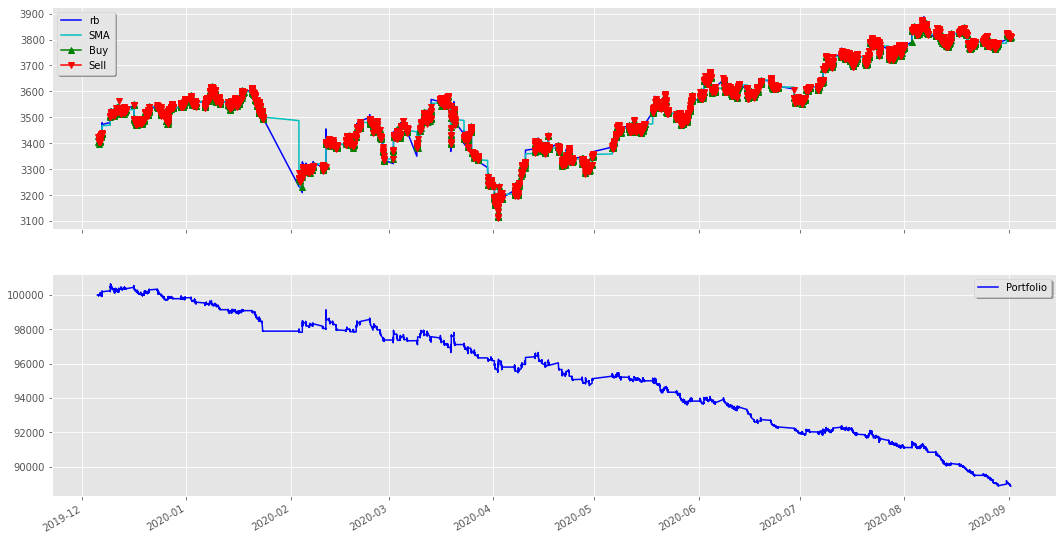

In [6]:
from pyalgotrade import strategy # 策略
from pyalgotrade import plotter # 做图
from pyalgotrade.technical import ma # 技术方法
from pyalgotrade.technical import cross # 技术方法
from pyalgotrade.stratanalyzer import returns # 评价
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade.stratanalyzer import trades
from pyalgotrade.barfeed import membf,csvfeed
from pyalgotrade import bar
# import tushare as ts
import pandas as pd

class MyStrategy(strategy.BacktestingStrategy): # 继承策略的父类
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed,100000)
        self.__instrument = instrument
        self.__closed = feed.getDataSeries().getCloseDataSeries()
        self.__ma = ma.SMA(self.__closed, smaPeriod)
        self.__position = None
       
    def getSMA(self):
        return self.__ma
   
    def onEnterCanceled(self, position):
        self.__position = None
        print("onEnterCanceled", position.getShares())
       
    def onExitOk(self, position):
        self.__position = None
        print("onExitOk", position.getShares())
       
    def onExitCanceled(self, position):
        self.__position.exitMarket()
        print("onExitCanceled", position.getShares())
       
    # 这个函数每天调一次
    def onBars(self, bars):
        bar = bars[self.__instrument] # bar是k线中的每个柱
        if self.__position is None: 
            if cross.cross_above(self.__closed, self.__ma) > 0:
                shares = int(self.getBroker().getCash() * 0.3 / bar.getPrice())
                print("cross_above shares,", shares)
                self.__position = self.enterLong(self.__instrument, shares, True)
        elif not self.__position.exitActive() and cross.cross_below(self.__closed, self.__ma) > 0:
            print("cross_below", bar.getPrice(), bar.getClose(), bar.getDateTime())
            # print(bars.keys())
            print("length", len(self.__closed), self.__closed[-1])
            self.__position.exitMarket()

    def getClose(self):
        return self.__closed

code = 'rb'
feed = csvfeed.GenericBarFeed(bar.Frequency.MONTH)
feed.addBarsFromCSV(code,'./data/performance/rb.csv')


myStrategy = MyStrategy(feed, code, 20) # 最重要的策略类
plt = plotter.StrategyPlotter(myStrategy) # 做图分析
plt.getInstrumentSubplot(code).addDataSeries("SMA", myStrategy.getSMA())

retAnalyzer = returns.Returns() # 评价
myStrategy.attachAnalyzer(retAnalyzer)
sharpeRatioAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeRatioAnalyzer)
drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)
tradesAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradesAnalyzer)

myStrategy.run() # 开始运行，然后事件驱动
myStrategy.info("最终投资组合价值: $%.2f" % myStrategy.getResult())

print("最终资产价值: $%.2f" % myStrategy.getResult())
print("累计回报率: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100))
print("夏普比率: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.05)))
print("最大回撤率: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("最长回撤时间: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("总交易 Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("利润", "mean", round(profits.mean(),2), "std", round(profits.std(),2),
          "max", round(profits.max(),2), "min", round(profits.min(),2))
    returns = tradesAnalyzer.getAllReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
print("")
print("赢利交易 Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("利润", "mean", round(profits.mean(),2), "std", round(profits.std(),2),
          "max", round(profits.max(),2), "min", round(profits.min(),2))
    returns = tradesAnalyzer.getPositiveReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
print("")
print("亏损交易Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("利润", "mean", round(losses.mean(),2), "std", round(losses.std(),2),
          "max", round(losses.max(),2), "min", round(losses.min(),2))
    returns = tradesAnalyzer.getNegativeReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
  
plt.plot()

### `PyAlgoTrade`的组成

<center><img src="./img/performance/pyalgotrade.png" width=100%></center>

- 数据源：数据接口
    - k线历史价格数据
    - Twitter的数据源，将 Tiwtter 的事件整合进交易决策中

- 券商：负责执行交易指令

- 数据序列：管理时间序列数据的接口

- 技术指标：基于数据序列而生成的一系列技术指标

- 优化器：可以实现在一台计算的多个进程中，或者多台计算机中运行回测

### 数据源

- `feed`类实现数据源管理，主要功能包括：
    - 读取`csv`格式存储的交易数据
    - 在策略的事件循环中产生新的数据

#### 生成`feed`类

```python
    pyalgotrade.barfeed.csvfeed.GenericBarFeed(frequency)
```
- 从`csv`文件中读入数据

- 要求`csv`文件中数据要求满足下列格式

Date Time|Open|High|Low|Close|Volume|Adj Close
---|---|---|---|---|---|---
2020-10-10 14:32:00|3600|3700|3480|3650|112|

- `frequency`：K线的时间长度，可以取值`SECOND,MINUTE,HOUR,DAY,WEEK,MONTH`

- 建立一个读取`csv`文件的`feed`类
```python
    from pyalgotrade.barfeed import csvfeed
    from pyalgotrade.bar import Frequency
    feed = csvfeed.GenericBarFeed(Frequency.MINUTE)
```

#### 加载数据

- `feed`类的方法
```python
   addBarsFromCSV(instrument,path)
```
- `instrument`：标的的名称
- `path`：数据文件的路径

- 给建立的`feed`类的对象加载`rb`的交易数据

```python
    feed.addBarsFromCSV('rb','./data/performance/rb.csv')
```

In [8]:
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)

In [9]:
type(myfeed)

pyalgotrade.barfeed.csvfeed.GenericBarFeed

In [10]:
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

#### 获取k线序列

```python
    feed[instrument]
```
- 返回的是`pyalgotrade.dataseries.bards.BarDataSeries`类的对象

In [11]:
type(myfeed['rb'])

pyalgotrade.dataseries.bards.BarDataSeries

- 该类的主要方法
    - `getCloseDataSeries()`
    - `getHighDataSeries()`
    - `getLowDataSeries()`
    - `getOpenDataSeries()`
    - `getVolumeDataSeries()`
- 均返回的是`pyalgotrade.dataseries.DataSeries`类的对象

##### BarDataSeries与DataSeries

<center><img src="./img/performance/barDataSeries.png" width=100%></center>

### 技术分析

#### 趋势指标

```python
    pyalgotrade.technical.ma.SMA(dataSeries, period)
```
- 简单移动平均
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.ma.EMA(dataSeries, period)
```
- 指数移动平均
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.ma.VWAP(dataSeries, period)
```
- 成交量加权的移动平均
- `dataSeries`：***`BarDataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.macd.MACD(dataSeries, fastEMA, slowEMA, signalEMA)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `fastEMA`：短期时间窗口长度
- `slowEMA`：长期时间窗口长度
- `signalEMA`：信号线时间窗口长度

- 方法
    - `getHistogram()`：获得`MACD`线与`Signal`线之间的差
    - `getSignal()`：获得信号线的`DataSeries`数据序列

#### 能量指标

```python
    pyalgotrade.technical.rsi.RSI(dataSeries, period)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

#### 波动性指标

```python
    pyalgotrade.technical.atr.ATR(barDataSeries, period)
```
- `barDataSeries`：***`BarDataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.bollinger.BollingerBands(dataSeries, period，numStdDev)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度
- `numStdDev`：标准差的倍数

- 方法
    - `getLowerBand()`：获得Bollinger的下界
    - `getUpperBand()`：获得Bollinger的上界
    - `getMiddleBand()`：获得Bollinger的中线

#### 其他指标

```python
    pyalgotrade.technical.cross.cross_above(dataSeries1, dataSeries2)
```
- 检查两个数据序列的**向上**穿越条件
- `dataSeries1`：***`DataSeries`***类的数据序列，穿越的序列
- `dataSeries2`：***`DataSeries`***类的数据序列，被穿越的序列

```python
    pyalgotrade.technical.cross.cross_below(dataSeries1, dataSeries2)
```
- 检查两个数据序列的**向下**穿越条件
- `dataSeries1`：***`DataSeries`***类的数据序列，穿越的序列
- `dataSeries2`：***`DataSeries`***类的数据序列，被穿越的序列

```python
    pyalgotrade.technical.highlow.High(dataSeries, period)
```
- 计算时间窗口内的**最高值**
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.highlow.Low(dataSeries, period)
```
- 计算时间窗口内的**最低值**
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

#### 调用`TA-Lib`

- 通过`pyalgotrade.talibext.indicator`实现对`TA-Lib`的调用

```python
    pyalgotrade.talibext.indicator.BBANDS(ds, count, matype)
```
- `ds`：***`DataSeries`***类的数据序列
- `count`：需要用到的数据数量

```python
    pyalgotrade.talibext.indicator.ATR(barDs, count, timeperiod)
```
- `barDs`：***`BarDataSeries`***类型的数据序列
- `count`：需要用到的数据数量
- `timeperiod`：时间窗口长度

### 策略

- 策略：实现交易逻辑的**类**

```python

from pyalgotrade import strategy
 
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MyStrategy, self).__init__(feed) # 初始化函数
        self.__instrument = instrument # 交易的品种
 
    def onBars(self, bars):# 每一个数据都会抵达这里，就像backtest中的next
        bar = bars[self.__instrument]
        self.info(bar.getClose())# 我们打印输出收盘价
```

#### 类与对象

- 面向对象编程（object oriented programming，OOP）：是一种程序设计思想。OOP把对象作为程序的基本单元，一个对象包含了数据和操作数据的函数

- 类是对象的抽象，对象是类的实例

##### 定义类

- 用`class`关键字

```python
class Student(object):
    pass
```

- 建立对象

```python
studentA = Student()
studentB = Student()
```

##### 定义属性 

In [ ]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0

- `def __init__(self)`：初始化函数，建立对象的时候调用该函数，`self`**必不可少**

###### 建立对象

In [ ]:
studentA = Student('Mike','male',100,90)
studentB = Student('Suzen','female',80,95)

###### 调用属性

In [ ]:
studentA.name
studentB.name
studentA.mathScore
studentB.grade

##### 定义方法

In [ ]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0
    def total_score(self):
        self.grade = self.mathScore + self.englishScore

###### 建立对象

In [ ]:
studentA = Student('Mike','male',100,90)
studentB = Student('Suzen','female',80,95)

###### 调用方法

In [ ]:
studentA.total_score()
studentB.total_score()
studentA.grade
studentB.grade

##### 定义更多方法

In [ ]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0
        
    def total_score(self):
        self.grade = self.mathScore + self.englishScore
    
    def show_grade(self):
        print(f'{self.name}的总成绩是{self.grade}')

In [ ]:
studentLst = []
studentLst.append(Student('Mike','male',100,90))
studentLst.append(Student('Suzen','female',80,95))

In [ ]:
for each in studentLst:
    each.total_score()
    each.show_grade()

#### 简单均线策略

- 如果分钟收盘价**向上突破**15分钟均线，建立**多头头寸**
- 如果分钟收盘价**向下突破**15分钟均线，并且**已经有多头仓位**，那么**平掉该多头仓位**

##### 建立策略类

```python
from pyalgotrade import strategy
from pyalgotrade.technical import ma
```

###### 定义属性

```python
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000) # 初始资金50000元
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(),smaPeriod) # 计算均线
```

- 属性
    - `self.__position`：记录仓位
    - `self.__instrument`：交易品种
    - `self.__sma`：均线

###### 定义方法：产生交易信号

```python
def onBars(self,bars):
    pass
```

- 交易逻辑都要体现在该方法（函数）中
- 唯一参数`bars`：是一个字典，`key`是交易标的名称，`value`是当前的k线数据
- k线数据：`pyalgotrade.bar.Bar`类的对象，该类的方法包括
    - `getDateTime()`
    - `getOpen()`
    - `getHigh()`
    - `getLow()`
    - `getClose()`
    - `getVolume()`
    - `getTypicalPrice()`
    - `getPrice()`：收盘价

<center><img src="./img/performance/bars.png" width=100%></center>

- 属于同一个bars的所有bar的`Date Time`必须一样

```python
    def onBars(self,bars):
        # 当移动均值存在的时候运行，否则返回
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]  # 获取需要交易品种的当前k线数据
        if self.__position is None:   # 判断当前是否有仓位
            if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
                pass
        elif bar.getPrice() < self.__sma[-1]:  # 平多仓条件
            pass
```

- `self.__sma[-1]`：移动平均序列向前移动一个周期

> 避免前瞻性偏差

### 下单指令

#### 建仓

##### 建仓交互过程

<center><img src="./img/performance/enterPosSeq.svg" width=100%></center>

##### 建仓命令

```python
    Strategy.enterLong(instrument,quantity)
    Strategy.enterShort(instrument,quantity)
```

- `instrument`：`str`类型，交易品种名称
- `quantity`：`int`类型，下单的数量

- 执行市价单

- 返回的是一个仓位类型，`pyalgotrade.strategy.position.Position`

##### 持仓

- `pyalgotrade.strategy.position.Position`类，该类有如下方法

- `getShares()`：获取持仓的数量
    - 正整数：多头仓位
    - 负整数：空头仓位
    - 0：仓位已经平掉，或者处于挂单状态，还未成交

- `getReturn(includeComissions=True)`：截至到当前时点，该仓位的累积收益率

- `getPnL(includeCommissions=True)`：截至到当前时点，该仓位的收益和损失（Profit and Loss）

- `getEntryOrder()`：获得建立该仓位对应的下单

- `getExitOrder()`：获得平掉该仓位对应的下单

##### 建仓成功的回复

```python
Strategy.onEnterOK(Position)
```

- 需要自定义内容的函数

#### 平仓

##### 平仓交互过程

<center><img src="./img/performance/exitPosSeq.svg" width=100%></center>

##### 平仓命令

- `Position.exitMarket()`：用**市价单**平掉仓位

##### 把建仓命令和平仓命令应用到策略中

```python
    def onBars(self,bars):
        bar = bars[self.__instrument]  # 获取需要交易标的的当前k线数据
        if self.__position is None:   # 判断当前是否有仓位
            if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
                self.__position = self.enterLong(self.__instrument, 5)  # 建立多仓
        elif bar.getPrice() < self.__sma[-1]:  # 平多仓条件
            self.__position.exitMarket()  # 平仓
```

- 平仓之前还需要判断一下是否有平仓的挂单

```python
def onBars(self,bars):
    bar = bars[self.__instrument]  # 获取需要交易标的的当前k线数据
    if self.__position is None:   # 判断当前是否有仓位
        if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
            self.__position = self.enterLong(self.__instrument, 5)       # 建立5手多单
    elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():  # 平多仓条件 并且当前没有平仓的挂单
        self.__position.exitMarket()
```

##### 平仓成功的回复

```python
    Strategy.onExitOK(Position)
```

- 需要自定义的函数

#### 查询是否有挂单

##### 挂单

<center><img src="./img/performance/listing.jpg" width=100%></center>

##### 查询是否有挂单交互过程

<center><img src="./img/performance/listOrderSeq.svg" width=100%></center>

##### 查询挂单命令

```python
    # 查询是否有开仓挂单
    Position.entryActive()
    # 查询是否有平仓挂单
    Position.exitActive()
```

- 如果有建仓（平仓）的挂单，返回`True`，否则为`False`

#### 查询下单是否成交

##### 查询下单是否成交交互过程

<center><img src="./img/performance/filledOrderSeq.svg" width=100%></center>

##### 查询是否成交命令

```python
    # 查询开仓单是否成交
    Position.entryFilled()
    # 查询平仓单是否成交
    Position.exitFilled()
```

- 如果建仓（平仓）的挂单已经成交，返回`True`，否则为`False`

#### 撤销下单

##### 撤单交互过程

<center><img src="./img/performance/cancelOrderSeq.svg" width=100%></center>

##### 撤单命令


```python
    # 撤销开仓单
    Position.cancelEntry()
    # 撤销平仓单
    Position.cancelExit()
```

##### 撤单回复

```python
    # 撤销开仓单的回复
    Strategy.onEnterCanceled(Position)
    # 撤销平仓单的回复
    Strategy.onExitCanceled(Position)
```

- 均是需要自定义的函数

### 券商

#### 下单管理模块

##### `pyalgotrade.broker.Order`类

- 该类的方法
    - `getType()`：获取该订单的类型，包括市价单(MARKET)、限价单(LIMIT)、止损单(STOP)等
    - `getAction()`：获取该订单执行的方向，包括BUY、BUY_TO_COVER、SELL、SELL_SHORT    
    - `getState()`：获取该订单的状态，包括提交(SUBMITTED)、被交易所接收(ACCEPTED)、撤销(CANCELED)、成交(FILLED)等
    - `getExecutionInfo()`：获取订单的执行信息，返回`pyalgotrade.broker.OrderExecutionInfo`类的对象
    
方向|开仓|平仓
---|---|---
多|BUY|SELL
空|SELL_SHORT|BUY_TO_COVER

##### `pyalgotrade.broker.OrderExecutionInfo`类

- 该类的方法
    - `getPrice()`：实际成交价格
    - `getQuantity()`：实际成交数量

##### 自定义开仓成功和平仓成功函数

```python
    def onEnterOK(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice()：.2f}，数量为{execInfo.getQuantity()}')
```

```python
    def onExitOK(position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
        self.__position = None   # 清空仓位
```

#### 完整策略

```python
    from pyalgotrade import strategy
    from pyalgotrade.technical import ma
    
    class MyStrategy(strategy.BacktestingStrategy):
        def __init__(self, feed, instrument, smaPeriod):
            super(MyStrategy, self).__init__(feed, 50000)
            self.__position = None
            self.__instrument = instrument
            self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

        def onEnterOk(self, position):
            execInfo = position.getEntryOrder().getExecutionInfo()
            self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

        def onExitOk(self, position):
            execInfo = position.getExitOrder().getExecutionInfo()
            self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
            self.__position = None

        def onBars(self, bars):
            if self.__sma[-1] is None:
                return

            bar = bars[self.__instrument]
            if self.__position is None:
                if bar.getPrice() > self.__sma[-1]:
                    self.__position = self.enterLong(self.__instrument, 5)
            elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
                self.__position.exitMarket()
```

### 运行策略

```python
    Strategy.run()
```
- 运行策略，仅能调用**一次**

- 建立策略类

In [33]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}，PnL为{position.getPnL()}')
        self.__position = None

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                self.__position = self.enterLong(self.__instrument, 5)
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()

- 建立数据源并读入数据

In [34]:
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

- 建立策略对象并初始化

In [35]:
myStrategy = MyStrategy(myfeed,'rb',15)

- 运行策略

In [37]:
myStrategy.run()

2019-12-05 14:33:00 strategy [INFO] 建多仓，价格为3426.00，数量为5
2019-12-05 14:39:00 strategy [INFO] 平多仓，价格为3425.00，数量为5，PnL为-5.0
2019-12-05 14:44:00 strategy [INFO] 建多仓，价格为3426.00，数量为5
2019-12-05 14:45:00 strategy [INFO] 平多仓，价格为3423.00，数量为5，PnL为-15.0
2019-12-05 21:08:00 strategy [INFO] 建多仓，价格为3403.00，数量为5
2019-12-05 21:18:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为5.0
2019-12-05 21:19:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:21:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为-5.0
2019-12-05 21:23:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:36:00 strategy [INFO] 平多仓，价格为3407.00，数量为5，PnL为10.0
2019-12-05 21:39:00 strategy [INFO] 建多仓，价格为3408.00，数量为5
2019-12-05 21:40:00 strategy [INFO] 平多仓，价格为3407.00，数量为5，PnL为-5.0
2019-12-05 21:54:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:55:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为-5.0
2019-12-05 22:01:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 22:13:00 strategy [INFO] 平多仓，价格为3405.00，数量为5，PnL为0.0
2019-12-05 22:17:00 strategy [INF

2019-12-09 22:02:00 strategy [INFO] 建多仓，价格为3514.00，数量为5
2019-12-09 22:12:00 strategy [INFO] 平多仓，价格为3515.00，数量为5，PnL为5.0
2019-12-09 22:15:00 strategy [INFO] 建多仓，价格为3516.00，数量为5
2019-12-09 22:17:00 strategy [INFO] 平多仓，价格为3514.00，数量为5，PnL为-10.0
2019-12-09 22:30:00 strategy [INFO] 建多仓，价格为3514.00，数量为5
2019-12-09 22:41:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为-10.0
2019-12-09 22:42:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-09 22:47:00 strategy [INFO] 平多仓，价格为3514.00，数量为5，PnL为5.0
2019-12-09 22:50:00 strategy [INFO] 建多仓，价格为3514.00，数量为5
2019-12-09 22:52:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为-10.0
2019-12-10 09:01:00 strategy [INFO] 建多仓，价格为3512.00，数量为5
2019-12-10 09:29:00 strategy [INFO] 平多仓，价格为3518.00，数量为5，PnL为30.0
2019-12-10 09:41:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2019-12-10 09:45:00 strategy [INFO] 平多仓，价格为3517.00，数量为5，PnL为-5.0
2019-12-10 09:46:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2019-12-10 09:48:00 strategy [INFO] 平多仓，价格为3517.00，数量为5，PnL为-5.0
2019-12-10 09:49:00 strategy [I

2019-12-12 09:21:00 strategy [INFO] 建多仓，价格为3523.00，数量为5
2019-12-12 09:22:00 strategy [INFO] 平多仓，价格为3522.00，数量为5，PnL为-5.0
2019-12-12 09:40:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2019-12-12 09:41:00 strategy [INFO] 平多仓，价格为3516.00，数量为5，PnL为-10.0
2019-12-12 09:44:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2019-12-12 10:03:00 strategy [INFO] 平多仓，价格为3521.00，数量为5，PnL为15.0
2019-12-12 10:04:00 strategy [INFO] 建多仓，价格为3523.00，数量为5
2019-12-12 10:10:00 strategy [INFO] 平多仓，价格为3523.00，数量为5，PnL为0.0
2019-12-12 10:35:00 strategy [INFO] 建多仓，价格为3521.00，数量为5
2019-12-12 10:36:00 strategy [INFO] 平多仓，价格为3519.00，数量为5，PnL为-10.0
2019-12-12 10:37:00 strategy [INFO] 建多仓，价格为3521.00，数量为5
2019-12-12 10:38:00 strategy [INFO] 平多仓，价格为3518.00，数量为5，PnL为-15.0
2019-12-12 10:59:00 strategy [INFO] 建多仓，价格为3515.00，数量为5
2019-12-12 11:00:00 strategy [INFO] 平多仓，价格为3513.00，数量为5，PnL为-10.0
2019-12-12 11:01:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-12 11:02:00 strategy [INFO] 平多仓，价格为3513.00，数量为5，PnL为0.0
2019-12-12 11:13:00 strategy [

2019-12-16 13:39:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2019-12-16 13:40:00 strategy [INFO] 平多仓，价格为3493.00，数量为5，PnL为-5.0
2019-12-16 13:41:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2019-12-16 13:47:00 strategy [INFO] 平多仓，价格为3491.00，数量为5，PnL为-15.0
2019-12-16 14:08:00 strategy [INFO] 建多仓，价格为3490.00，数量为5
2019-12-16 14:14:00 strategy [INFO] 平多仓，价格为3488.00，数量为5，PnL为-10.0
2019-12-16 14:15:00 strategy [INFO] 建多仓，价格为3489.00，数量为5
2019-12-16 14:21:00 strategy [INFO] 平多仓，价格为3488.00，数量为5，PnL为-5.0
2019-12-16 14:28:00 strategy [INFO] 建多仓，价格为3489.00，数量为5
2019-12-16 14:29:00 strategy [INFO] 平多仓，价格为3488.00，数量为5，PnL为-5.0
2019-12-16 14:30:00 strategy [INFO] 建多仓，价格为3488.00，数量为5
2019-12-16 14:36:00 strategy [INFO] 平多仓，价格为3489.00，数量为5，PnL为5.0
2019-12-16 14:56:00 strategy [INFO] 建多仓，价格为3482.00，数量为5
2019-12-16 15:00:00 strategy [INFO] 平多仓，价格为3480.00，数量为5，PnL为-10.0
2019-12-16 20:59:00 strategy [INFO] 建多仓，价格为3482.00，数量为5
2019-12-16 21:02:00 strategy [INFO] 平多仓，价格为3475.00，数量为5，PnL为-35.0
2019-12-16 21:13:00 strategy 

2019-12-20 14:41:00 strategy [INFO] 建多仓，价格为3508.00，数量为5
2019-12-20 14:44:00 strategy [INFO] 平多仓，价格为3506.00，数量为5，PnL为-10.0
2019-12-20 14:47:00 strategy [INFO] 建多仓，价格为3508.00，数量为5
2019-12-20 14:49:00 strategy [INFO] 平多仓，价格为3508.00，数量为5，PnL为0.0
2019-12-20 14:58:00 strategy [INFO] 建多仓，价格为3507.00，数量为5
2019-12-20 21:29:00 strategy [INFO] 平多仓，价格为3518.00，数量为5，PnL为55.0
2019-12-20 21:30:00 strategy [INFO] 建多仓，价格为3520.00，数量为5
2019-12-20 21:32:00 strategy [INFO] 平多仓，价格为3518.00，数量为5，PnL为-10.0
2019-12-20 21:36:00 strategy [INFO] 建多仓，价格为3521.00，数量为5
2019-12-20 21:46:00 strategy [INFO] 平多仓，价格为3520.00，数量为5，PnL为-5.0
2019-12-20 21:47:00 strategy [INFO] 建多仓，价格为3523.00，数量为5
2019-12-20 22:03:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为15.0
2019-12-20 22:06:00 strategy [INFO] 建多仓，价格为3526.00，数量为5
2019-12-20 22:07:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为0.0
2019-12-20 22:10:00 strategy [INFO] 建多仓，价格为3527.00，数量为5
2019-12-20 22:11:00 strategy [INFO] 平多仓，价格为3527.00，数量为5，PnL为0.0
2019-12-20 22:14:00 strategy [INF

2019-12-24 21:26:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-24 21:29:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为-5.0
2019-12-24 21:36:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-24 21:37:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为-5.0
2019-12-24 21:41:00 strategy [INFO] 建多仓，价格为3514.00，数量为5
2019-12-24 21:44:00 strategy [INFO] 平多仓，价格为3511.00，数量为5，PnL为-15.0
2019-12-24 21:45:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-24 21:49:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为-5.0
2019-12-24 21:50:00 strategy [INFO] 建多仓，价格为3512.00，数量为5
2019-12-24 21:57:00 strategy [INFO] 平多仓，价格为3512.00，数量为5，PnL为0.0
2019-12-24 22:04:00 strategy [INFO] 建多仓，价格为3512.00，数量为5
2019-12-24 22:15:00 strategy [INFO] 平多仓，价格为3511.00，数量为5，PnL为-5.0
2019-12-24 22:21:00 strategy [INFO] 建多仓，价格为3513.00，数量为5
2019-12-24 22:24:00 strategy [INFO] 平多仓，价格为3511.00，数量为5，PnL为-10.0
2019-12-24 22:25:00 strategy [INFO] 建多仓，价格为3512.00，数量为5
2019-12-24 22:26:00 strategy [INFO] 平多仓，价格为3511.00，数量为5，PnL为-5.0
2019-12-24 22:28:00 strategy [I

2019-12-26 22:56:00 strategy [INFO] 建多仓，价格为3533.00，数量为5
2019-12-26 22:57:00 strategy [INFO] 平多仓，价格为3531.00，数量为5，PnL为-10.0
2019-12-26 22:59:00 strategy [INFO] 建多仓，价格为3531.00，数量为5
2019-12-27 09:00:00 strategy [INFO] 平多仓，价格为3532.00，数量为5，PnL为5.0
2019-12-27 09:01:00 strategy [INFO] 建多仓，价格为3534.00，数量为5
2019-12-27 09:06:00 strategy [INFO] 平多仓，价格为3531.00，数量为5，PnL为-15.0
2019-12-27 09:07:00 strategy [INFO] 建多仓，价格为3533.00，数量为5
2019-12-27 09:25:00 strategy [INFO] 平多仓，价格为3533.00，数量为5，PnL为0.0
2019-12-27 09:35:00 strategy [INFO] 建多仓，价格为3535.00，数量为5
2019-12-27 09:39:00 strategy [INFO] 平多仓，价格为3531.00，数量为5，PnL为-20.0
2019-12-27 09:50:00 strategy [INFO] 建多仓，价格为3530.00，数量为5
2019-12-27 10:09:00 strategy [INFO] 平多仓，价格为3535.00，数量为5，PnL为25.0
2019-12-27 10:15:00 strategy [INFO] 建多仓，价格为3536.00，数量为5
2019-12-27 10:48:00 strategy [INFO] 平多仓，价格为3538.00，数量为5，PnL为10.0
2019-12-27 10:57:00 strategy [INFO] 建多仓，价格为3538.00，数量为5
2019-12-27 11:13:00 strategy [INFO] 平多仓，价格为3538.00，数量为5，PnL为0.0
2019-12-27 11:17:00 strategy [IN

2019-12-31 09:55:00 strategy [INFO] 建多仓，价格为3548.00，数量为5
2019-12-31 09:56:00 strategy [INFO] 平多仓，价格为3546.00，数量为5，PnL为-10.0
2019-12-31 10:00:00 strategy [INFO] 建多仓，价格为3547.00，数量为5
2019-12-31 10:02:00 strategy [INFO] 平多仓，价格为3547.00，数量为5，PnL为0.0
2019-12-31 10:03:00 strategy [INFO] 建多仓，价格为3547.00，数量为5
2019-12-31 10:44:00 strategy [INFO] 平多仓，价格为3557.00，数量为5，PnL为50.0
2019-12-31 10:45:00 strategy [INFO] 建多仓，价格为3558.00，数量为5
2019-12-31 10:46:00 strategy [INFO] 平多仓，价格为3556.00，数量为5，PnL为-10.0
2019-12-31 10:49:00 strategy [INFO] 建多仓，价格为3558.00，数量为5
2019-12-31 10:50:00 strategy [INFO] 平多仓，价格为3557.00，数量为5，PnL为-5.0
2019-12-31 10:52:00 strategy [INFO] 建多仓，价格为3558.00，数量为5
2019-12-31 10:53:00 strategy [INFO] 平多仓，价格为3558.00，数量为5，PnL为0.0
2019-12-31 10:58:00 strategy [INFO] 建多仓，价格为3557.00，数量为5
2019-12-31 11:01:00 strategy [INFO] 平多仓，价格为3557.00，数量为5，PnL为0.0
2019-12-31 11:04:00 strategy [INFO] 建多仓，价格为3558.00，数量为5
2019-12-31 11:29:00 strategy [INFO] 平多仓，价格为3565.00，数量为5，PnL为35.0
2019-12-31 13:34:00 strategy [INF

2020-01-07 21:32:00 strategy [INFO] 建多仓，价格为3580.00，数量为5
2020-01-07 22:02:00 strategy [INFO] 平多仓，价格为3593.00，数量为5，PnL为65.0
2020-01-07 22:03:00 strategy [INFO] 建多仓，价格为3595.00，数量为5
2020-01-07 22:07:00 strategy [INFO] 平多仓，价格为3594.00，数量为5，PnL为-5.0
2020-01-07 22:08:00 strategy [INFO] 建多仓，价格为3595.00，数量为5
2020-01-07 22:21:00 strategy [INFO] 平多仓，价格为3599.00，数量为5，PnL为20.0
2020-01-07 22:28:00 strategy [INFO] 建多仓，价格为3600.00，数量为5
2020-01-07 22:31:00 strategy [INFO] 平多仓，价格为3598.00，数量为5，PnL为-10.0
2020-01-07 22:34:00 strategy [INFO] 建多仓，价格为3599.00，数量为5
2020-01-07 22:40:00 strategy [INFO] 平多仓，价格为3599.00，数量为5，PnL为0.0
2020-01-07 22:42:00 strategy [INFO] 建多仓，价格为3601.00，数量为5
2020-01-07 22:48:00 strategy [INFO] 平多仓，价格为3601.00，数量为5，PnL为0.0
2020-01-07 22:49:00 strategy [INFO] 建多仓，价格为3601.00，数量为5
2020-01-07 23:00:00 strategy [INFO] 平多仓，价格为3603.00，数量为5，PnL为10.0
2020-01-08 09:06:00 strategy [INFO] 建多仓，价格为3605.00，数量为5
2020-01-08 09:38:00 strategy [INFO] 平多仓，价格为3616.00，数量为5，PnL为55.0
2020-01-08 09:39:00 strategy [INF

2020-01-13 22:49:00 strategy [INFO] 建多仓，价格为3539.00，数量为5
2020-01-13 22:51:00 strategy [INFO] 平多仓，价格为3538.00，数量为5，PnL为-5.0
2020-01-13 22:52:00 strategy [INFO] 建多仓，价格为3538.00，数量为5
2020-01-13 22:53:00 strategy [INFO] 平多仓，价格为3538.00，数量为5，PnL为0.0
2020-01-13 22:56:00 strategy [INFO] 建多仓，价格为3539.00，数量为5
2020-01-14 09:16:00 strategy [INFO] 平多仓，价格为3544.00，数量为5，PnL为25.0
2020-01-14 09:25:00 strategy [INFO] 建多仓，价格为3544.00，数量为5
2020-01-14 09:26:00 strategy [INFO] 平多仓，价格为3544.00，数量为5，PnL为0.0
2020-01-14 09:27:00 strategy [INFO] 建多仓，价格为3546.00，数量为5
2020-01-14 09:29:00 strategy [INFO] 平多仓，价格为3544.00，数量为5，PnL为-10.0
2020-01-14 09:30:00 strategy [INFO] 建多仓，价格为3545.00，数量为5
2020-01-14 09:32:00 strategy [INFO] 平多仓，价格为3545.00，数量为5，PnL为0.0
2020-01-14 09:41:00 strategy [INFO] 建多仓，价格为3542.00，数量为5
2020-01-14 09:44:00 strategy [INFO] 平多仓，价格为3539.00，数量为5，PnL为-15.0
2020-01-14 10:01:00 strategy [INFO] 建多仓，价格为3538.00，数量为5
2020-01-14 10:15:00 strategy [INFO] 平多仓，价格为3539.00，数量为5，PnL为5.0
2020-01-14 10:31:00 strategy [INFO

2020-01-16 14:30:00 strategy [INFO] 建多仓，价格为3553.00，数量为5
2020-01-16 14:35:00 strategy [INFO] 平多仓，价格为3552.00，数量为5，PnL为-5.0
2020-01-16 14:45:00 strategy [INFO] 建多仓，价格为3551.00，数量为5
2020-01-16 21:15:00 strategy [INFO] 平多仓，价格为3564.00，数量为5，PnL为65.0
2020-01-16 21:26:00 strategy [INFO] 建多仓，价格为3567.00，数量为5
2020-01-16 21:36:00 strategy [INFO] 平多仓，价格为3564.00，数量为5，PnL为-15.0
2020-01-16 21:39:00 strategy [INFO] 建多仓，价格为3566.00，数量为5
2020-01-16 21:40:00 strategy [INFO] 平多仓，价格为3566.00，数量为5，PnL为0.0
2020-01-16 21:41:00 strategy [INFO] 建多仓，价格为3567.00，数量为5
2020-01-16 21:43:00 strategy [INFO] 平多仓，价格为3567.00，数量为5，PnL为0.0
2020-01-16 21:44:00 strategy [INFO] 建多仓，价格为3567.00，数量为5
2020-01-16 21:48:00 strategy [INFO] 平多仓，价格为3566.00，数量为5，PnL为-5.0
2020-01-16 21:49:00 strategy [INFO] 建多仓，价格为3567.00，数量为5
2020-01-16 21:58:00 strategy [INFO] 平多仓，价格为3568.00，数量为5，PnL为5.0
2020-01-16 22:08:00 strategy [INFO] 建多仓，价格为3569.00，数量为5
2020-01-16 22:18:00 strategy [INFO] 平多仓，价格为3568.00，数量为5，PnL为-5.0
2020-01-16 22:28:00 strategy [INFO

2020-01-23 09:20:00 strategy [INFO] 平多仓，价格为3522.00，数量为5，PnL为-5.0
2020-01-23 09:21:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2020-01-23 09:30:00 strategy [INFO] 平多仓，价格为3525.00，数量为5，PnL为0.0
2020-01-23 09:31:00 strategy [INFO] 建多仓，价格为3527.00，数量为5
2020-01-23 09:33:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为-5.0
2020-01-23 09:36:00 strategy [INFO] 建多仓，价格为3527.00，数量为5
2020-01-23 09:38:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为-5.0
2020-01-23 09:42:00 strategy [INFO] 建多仓，价格为3527.00，数量为5
2020-01-23 09:44:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为-5.0
2020-01-23 10:01:00 strategy [INFO] 建多仓，价格为3524.00，数量为5
2020-01-23 10:12:00 strategy [INFO] 平多仓，价格为3524.00，数量为5，PnL为0.0
2020-01-23 10:13:00 strategy [INFO] 建多仓，价格为3523.00，数量为5
2020-01-23 10:14:00 strategy [INFO] 平多仓，价格为3524.00，数量为5，PnL为5.0
2020-01-23 10:38:00 strategy [INFO] 建多仓，价格为3517.00，数量为5
2020-01-23 10:40:00 strategy [INFO] 平多仓，价格为3516.00，数量为5，PnL为-5.0
2020-01-23 10:42:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2020-01-23 10:48:00 strategy [INFO]

2020-02-06 10:41:00 strategy [INFO] 建多仓，价格为3294.00，数量为5
2020-02-06 10:43:00 strategy [INFO] 平多仓，价格为3293.00，数量为5，PnL为-5.0
2020-02-06 11:02:00 strategy [INFO] 建多仓，价格为3290.00，数量为5
2020-02-06 11:04:00 strategy [INFO] 平多仓，价格为3286.00，数量为5，PnL为-20.0
2020-02-06 11:08:00 strategy [INFO] 建多仓，价格为3289.00，数量为5
2020-02-06 11:11:00 strategy [INFO] 平多仓，价格为3287.00，数量为5，PnL为-10.0
2020-02-06 13:31:00 strategy [INFO] 建多仓，价格为3284.00，数量为5
2020-02-06 14:01:00 strategy [INFO] 平多仓，价格为3307.00，数量为5，PnL为115.0
2020-02-06 14:11:00 strategy [INFO] 建多仓，价格为3310.00，数量为5
2020-02-06 14:19:00 strategy [INFO] 平多仓，价格为3306.00，数量为5，PnL为-20.0
2020-02-06 14:35:00 strategy [INFO] 建多仓，价格为3303.00，数量为5
2020-02-06 14:51:00 strategy [INFO] 平多仓，价格为3303.00，数量为5，PnL为0.0
2020-02-06 14:54:00 strategy [INFO] 建多仓，价格为3309.00，数量为5
2020-02-06 14:55:00 strategy [INFO] 平多仓，价格为3308.00，数量为5，PnL为-5.0
2020-02-06 14:56:00 strategy [INFO] 建多仓，价格为3310.00，数量为5
2020-02-06 14:58:00 strategy [INFO] 平多仓，价格为3307.00，数量为5，PnL为-15.0
2020-02-07 09:22:00 strategy

2020-02-14 14:42:00 strategy [INFO] 建多仓，价格为3393.00，数量为5
2020-02-14 14:53:00 strategy [INFO] 平多仓，价格为3393.00，数量为5，PnL为0.0
2020-02-14 14:54:00 strategy [INFO] 建多仓，价格为3394.00，数量为5
2020-02-17 09:00:00 strategy [INFO] 平多仓，价格为3392.00，数量为5，PnL为-10.0
2020-02-17 09:02:00 strategy [INFO] 建多仓，价格为3399.00，数量为5
2020-02-17 09:06:00 strategy [INFO] 平多仓，价格为3393.00，数量为5，PnL为-30.0
2020-02-17 09:18:00 strategy [INFO] 建多仓，价格为3395.00，数量为5
2020-02-17 09:53:00 strategy [INFO] 平多仓，价格为3405.00，数量为5，PnL为50.0
2020-02-17 09:59:00 strategy [INFO] 建多仓，价格为3409.00，数量为5
2020-02-17 10:14:00 strategy [INFO] 平多仓，价格为3409.00，数量为5，PnL为0.0
2020-02-17 10:36:00 strategy [INFO] 建多仓，价格为3409.00，数量为5
2020-02-17 10:54:00 strategy [INFO] 平多仓，价格为3413.00，数量为5，PnL为20.0
2020-02-17 11:04:00 strategy [INFO] 建多仓，价格为3413.00，数量为5
2020-02-17 11:05:00 strategy [INFO] 平多仓，价格为3413.00，数量为5，PnL为0.0
2020-02-17 11:07:00 strategy [INFO] 建多仓，价格为3412.00，数量为5
2020-02-17 11:09:00 strategy [INFO] 平多仓，价格为3410.00，数量为5，PnL为-10.0
2020-02-17 11:22:00 strategy [IN

2020-02-26 13:58:00 strategy [INFO] 平多仓，价格为3452.00，数量为5，PnL为-10.0
2020-02-26 13:59:00 strategy [INFO] 建多仓，价格为3453.00，数量为5
2020-02-26 14:08:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为10.0
2020-02-26 14:10:00 strategy [INFO] 建多仓，价格为3456.00，数量为5
2020-02-26 14:11:00 strategy [INFO] 平多仓，价格为3456.00，数量为5，PnL为0.0
2020-02-26 14:12:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-02-26 14:13:00 strategy [INFO] 平多仓，价格为3456.00，数量为5，PnL为-5.0
2020-02-26 14:23:00 strategy [INFO] 建多仓，价格为3454.00，数量为5
2020-02-26 14:31:00 strategy [INFO] 平多仓，价格为3454.00，数量为5，PnL为0.0
2020-02-26 14:47:00 strategy [INFO] 建多仓，价格为3449.00，数量为5
2020-02-26 14:58:00 strategy [INFO] 平多仓，价格为3452.00，数量为5，PnL为15.0
2020-02-27 09:02:00 strategy [INFO] 建多仓，价格为3455.00，数量为5
2020-02-27 09:03:00 strategy [INFO] 平多仓，价格为3451.00，数量为5，PnL为-20.0
2020-02-27 09:31:00 strategy [INFO] 建多仓，价格为3425.00，数量为5
2020-02-27 09:47:00 strategy [INFO] 平多仓，价格为3424.00，数量为5，PnL为-5.0
2020-02-27 09:48:00 strategy [INFO] 建多仓，价格为3428.00，数量为5
2020-02-27 09:55:00 strategy [IN

2020-03-06 10:37:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-03-06 10:38:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为-10.0
2020-03-06 10:40:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-03-06 10:43:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为-10.0
2020-03-06 10:54:00 strategy [INFO] 建多仓，价格为3451.00，数量为5
2020-03-06 10:55:00 strategy [INFO] 平多仓，价格为3450.00，数量为5，PnL为-5.0
2020-03-06 10:56:00 strategy [INFO] 建多仓，价格为3453.00，数量为5
2020-03-06 10:58:00 strategy [INFO] 平多仓，价格为3450.00，数量为5，PnL为-15.0
2020-03-06 11:01:00 strategy [INFO] 建多仓，价格为3449.00，数量为5
2020-03-06 11:02:00 strategy [INFO] 平多仓，价格为3447.00，数量为5，PnL为-10.0
2020-03-06 11:04:00 strategy [INFO] 建多仓，价格为3450.00，数量为5
2020-03-06 11:10:00 strategy [INFO] 平多仓，价格为3450.00，数量为5，PnL为0.0
2020-03-06 11:11:00 strategy [INFO] 建多仓，价格为3450.00，数量为5
2020-03-06 11:14:00 strategy [INFO] 平多仓，价格为3450.00，数量为5，PnL为0.0
2020-03-06 11:25:00 strategy [INFO] 建多仓，价格为3447.00，数量为5
2020-03-06 11:30:00 strategy [INFO] 平多仓，价格为3447.00，数量为5，PnL为0.0
2020-03-06 13:30:00 strategy [I

2020-03-11 10:42:00 strategy [INFO] 平多仓，价格为3492.00，数量为5，PnL为-10.0
2020-03-11 10:44:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2020-03-11 10:45:00 strategy [INFO] 平多仓，价格为3491.00，数量为5，PnL为-15.0
2020-03-11 10:46:00 strategy [INFO] 建多仓，价格为3492.00，数量为5
2020-03-11 10:47:00 strategy [INFO] 平多仓，价格为3492.00，数量为5，PnL为0.0
2020-03-11 10:48:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2020-03-11 10:51:00 strategy [INFO] 平多仓，价格为3492.00，数量为5，PnL为-10.0
2020-03-11 10:52:00 strategy [INFO] 建多仓，价格为3493.00，数量为5
2020-03-11 10:53:00 strategy [INFO] 平多仓，价格为3492.00，数量为5，PnL为-5.0
2020-03-11 11:05:00 strategy [INFO] 建多仓，价格为3491.00，数量为5
2020-03-11 11:07:00 strategy [INFO] 平多仓，价格为3488.00，数量为5，PnL为-15.0
2020-03-11 11:08:00 strategy [INFO] 建多仓，价格为3489.00，数量为5
2020-03-11 13:32:00 strategy [INFO] 平多仓，价格为3513.00，数量为5，PnL为120.0
2020-03-11 13:45:00 strategy [INFO] 建多仓，价格为3511.00，数量为5
2020-03-11 13:53:00 strategy [INFO] 平多仓，价格为3508.00，数量为5，PnL为-15.0
2020-03-11 13:54:00 strategy [INFO] 建多仓，价格为3514.00，数量为5
2020-03-11 14:10:00 strateg

2020-03-20 11:10:00 strategy [INFO] 平多仓，价格为3501.00，数量为5，PnL为-25.0
2020-03-20 11:11:00 strategy [INFO] 建多仓，价格为3503.00，数量为5
2020-03-20 11:12:00 strategy [INFO] 平多仓，价格为3499.00，数量为5，PnL为-20.0
2020-03-20 11:13:00 strategy [INFO] 建多仓，价格为3503.00，数量为5
2020-03-20 11:19:00 strategy [INFO] 平多仓，价格为3497.00，数量为5，PnL为-30.0
2020-03-20 11:27:00 strategy [INFO] 建多仓，价格为3497.00，数量为5
2020-03-20 11:28:00 strategy [INFO] 平多仓，价格为3491.00，数量为5，PnL为-30.0
2020-03-20 13:38:00 strategy [INFO] 建多仓，价格为3486.00，数量为5
2020-03-20 13:39:00 strategy [INFO] 平多仓，价格为3480.00，数量为5，PnL为-30.0
2020-03-20 13:47:00 strategy [INFO] 建多仓，价格为3477.00，数量为5
2020-03-20 13:48:00 strategy [INFO] 平多仓，价格为3472.00，数量为5，PnL为-25.0
2020-03-20 13:53:00 strategy [INFO] 建多仓，价格为3473.00，数量为5
2020-03-20 13:54:00 strategy [INFO] 平多仓，价格为3469.00，数量为5，PnL为-20.0
2020-03-20 13:55:00 strategy [INFO] 建多仓，价格为3473.00，数量为5
2020-03-20 14:10:00 strategy [INFO] 平多仓，价格为3484.00，数量为5，PnL为55.0
2020-03-20 14:15:00 strategy [INFO] 建多仓，价格为3489.00，数量为5
2020-03-20 14:16:00 strat

2020-03-31 11:27:00 strategy [INFO] 建多仓，价格为3233.00，数量为5
2020-03-31 13:35:00 strategy [INFO] 平多仓，价格为3234.00，数量为5，PnL为5.0
2020-03-31 13:36:00 strategy [INFO] 建多仓，价格为3237.00，数量为5
2020-03-31 13:39:00 strategy [INFO] 平多仓，价格为3236.00，数量为5，PnL为-5.0
2020-03-31 13:40:00 strategy [INFO] 建多仓，价格为3238.00，数量为5
2020-03-31 13:45:00 strategy [INFO] 平多仓，价格为3236.00，数量为5，PnL为-10.0
2020-03-31 13:46:00 strategy [INFO] 建多仓，价格为3239.00，数量为5
2020-03-31 13:48:00 strategy [INFO] 平多仓，价格为3237.00，数量为5，PnL为-10.0
2020-03-31 13:49:00 strategy [INFO] 建多仓，价格为3240.00，数量为5
2020-03-31 13:50:00 strategy [INFO] 平多仓，价格为3237.00，数量为5，PnL为-15.0
2020-03-31 13:54:00 strategy [INFO] 建多仓，价格为3240.00，数量为5
2020-03-31 14:00:00 strategy [INFO] 平多仓，价格为3237.00，数量为5，PnL为-15.0
2020-03-31 14:11:00 strategy [INFO] 建多仓，价格为3235.00，数量为5
2020-03-31 14:13:00 strategy [INFO] 平多仓，价格为3234.00，数量为5，PnL为-5.0
2020-03-31 14:14:00 strategy [INFO] 建多仓，价格为3235.00，数量为5
2020-03-31 14:15:00 strategy [INFO] 平多仓，价格为3232.00，数量为5，PnL为-15.0
2020-03-31 14:16:00 strategy

2020-04-07 09:47:00 strategy [INFO] 平多仓，价格为3235.00，数量为5，PnL为5.0
2020-04-07 09:48:00 strategy [INFO] 建多仓，价格为3236.00，数量为5
2020-04-07 09:49:00 strategy [INFO] 平多仓，价格为3234.00，数量为5，PnL为-10.0
2020-04-07 09:51:00 strategy [INFO] 建多仓，价格为3237.00，数量为5
2020-04-07 09:53:00 strategy [INFO] 平多仓，价格为3233.00，数量为5，PnL为-20.0
2020-04-07 09:54:00 strategy [INFO] 建多仓，价格为3236.00，数量为5
2020-04-07 09:57:00 strategy [INFO] 平多仓，价格为3233.00，数量为5，PnL为-15.0
2020-04-07 10:03:00 strategy [INFO] 建多仓，价格为3236.00，数量为5
2020-04-07 10:06:00 strategy [INFO] 平多仓，价格为3232.00，数量为5，PnL为-20.0
2020-04-07 10:31:00 strategy [INFO] 建多仓，价格为3230.00，数量为5
2020-04-07 10:33:00 strategy [INFO] 平多仓，价格为3227.00，数量为5，PnL为-15.0
2020-04-07 10:38:00 strategy [INFO] 建多仓，价格为3229.00，数量为5
2020-04-07 10:40:00 strategy [INFO] 平多仓，价格为3226.00，数量为5，PnL为-15.0
2020-04-07 10:41:00 strategy [INFO] 建多仓，价格为3231.00，数量为5
2020-04-07 10:48:00 strategy [INFO] 平多仓，价格为3219.00，数量为5，PnL为-60.0
2020-04-07 11:11:00 strategy [INFO] 建多仓，价格为3212.00，数量为5
2020-04-07 11:16:00 strate

2020-04-10 13:41:00 strategy [INFO] 建多仓，价格为3315.00，数量为5
2020-04-10 13:44:00 strategy [INFO] 平多仓，价格为3313.00，数量为5，PnL为-10.0
2020-04-10 13:45:00 strategy [INFO] 建多仓，价格为3314.00，数量为5
2020-04-10 13:46:00 strategy [INFO] 平多仓，价格为3310.00，数量为5，PnL为-20.0
2020-04-10 13:48:00 strategy [INFO] 建多仓，价格为3317.00，数量为5
2020-04-10 14:14:00 strategy [INFO] 平多仓，价格为3324.00，数量为5，PnL为35.0
2020-04-10 14:16:00 strategy [INFO] 建多仓，价格为3327.00，数量为5
2020-04-10 14:18:00 strategy [INFO] 平多仓，价格为3325.00，数量为5，PnL为-10.0
2020-04-10 14:19:00 strategy [INFO] 建多仓，价格为3328.00，数量为5
2020-04-10 14:47:00 strategy [INFO] 平多仓，价格为3347.00，数量为5，PnL为95.0
2020-04-10 14:49:00 strategy [INFO] 建多仓，价格为3350.00，数量为5
2020-04-13 09:08:00 strategy [INFO] 平多仓，价格为3374.00，数量为5，PnL为120.0
2020-04-13 09:09:00 strategy [INFO] 建多仓，价格为3378.00，数量为5
2020-04-13 09:14:00 strategy [INFO] 平多仓，价格为3372.00，数量为5，PnL为-30.0
2020-04-13 09:25:00 strategy [INFO] 建多仓，价格为3374.00，数量为5
2020-04-13 09:26:00 strategy [INFO] 平多仓，价格为3368.00，数量为5，PnL为-30.0
2020-04-13 09:37:00 strate

2020-04-21 11:01:00 strategy [INFO] 建多仓，价格为3319.00，数量为5
2020-04-21 11:02:00 strategy [INFO] 平多仓，价格为3316.00，数量为5，PnL为-15.0
2020-04-21 11:03:00 strategy [INFO] 建多仓，价格为3319.00，数量为5
2020-04-21 11:11:00 strategy [INFO] 平多仓，价格为3316.00，数量为5，PnL为-15.0
2020-04-21 11:18:00 strategy [INFO] 建多仓，价格为3326.00，数量为5
2020-04-21 11:22:00 strategy [INFO] 平多仓，价格为3316.00，数量为5，PnL为-50.0
2020-04-21 13:33:00 strategy [INFO] 建多仓，价格为3316.00，数量为5
2020-04-21 13:34:00 strategy [INFO] 平多仓，价格为3313.00，数量为5，PnL为-15.0
2020-04-21 13:48:00 strategy [INFO] 建多仓，价格为3312.00，数量为5
2020-04-21 13:59:00 strategy [INFO] 平多仓，价格为3314.00，数量为5，PnL为10.0
2020-04-21 14:00:00 strategy [INFO] 建多仓，价格为3314.00，数量为5
2020-04-21 14:16:00 strategy [INFO] 平多仓，价格为3327.00，数量为5，PnL为65.0
2020-04-21 14:17:00 strategy [INFO] 建多仓，价格为3328.00，数量为5
2020-04-21 14:34:00 strategy [INFO] 平多仓，价格为3336.00，数量为5，PnL为40.0
2020-04-21 14:41:00 strategy [INFO] 建多仓，价格为3339.00，数量为5
2020-04-21 14:42:00 strategy [INFO] 平多仓，价格为3338.00，数量为5，PnL为-5.0
2020-04-21 14:43:00 strategy

2020-04-24 14:35:00 strategy [INFO] 建多仓，价格为3338.00，数量为5
2020-04-24 14:41:00 strategy [INFO] 平多仓，价格为3335.00，数量为5，PnL为-15.0
2020-04-24 14:44:00 strategy [INFO] 建多仓，价格为3336.00，数量为5
2020-04-24 14:50:00 strategy [INFO] 平多仓，价格为3336.00，数量为5，PnL为0.0
2020-04-24 14:53:00 strategy [INFO] 建多仓，价格为3336.00，数量为5
2020-04-27 09:06:00 strategy [INFO] 平多仓，价格为3339.00，数量为5，PnL为15.0
2020-04-27 09:23:00 strategy [INFO] 建多仓，价格为3328.00，数量为5
2020-04-27 09:26:00 strategy [INFO] 平多仓，价格为3327.00，数量为5，PnL为-5.0
2020-04-27 09:38:00 strategy [INFO] 建多仓，价格为3323.00，数量为5
2020-04-27 09:39:00 strategy [INFO] 平多仓，价格为3320.00，数量为5，PnL为-15.0
2020-04-27 09:42:00 strategy [INFO] 建多仓，价格为3320.00，数量为5
2020-04-27 09:43:00 strategy [INFO] 平多仓，价格为3317.00，数量为5，PnL为-15.0
2020-04-27 09:51:00 strategy [INFO] 建多仓，价格为3319.00，数量为5
2020-04-27 10:01:00 strategy [INFO] 平多仓，价格为3318.00，数量为5，PnL为-5.0
2020-04-27 10:04:00 strategy [INFO] 建多仓，价格为3319.00，数量为5
2020-04-27 10:36:00 strategy [INFO] 平多仓，价格为3339.00，数量为5，PnL为100.0
2020-04-27 10:37:00 strategy 

2020-04-29 14:15:00 strategy [INFO] 建多仓，价格为3297.00，数量为5
2020-04-29 14:19:00 strategy [INFO] 平多仓，价格为3297.00，数量为5，PnL为0.0
2020-04-29 14:28:00 strategy [INFO] 建多仓，价格为3295.00，数量为5
2020-04-29 14:29:00 strategy [INFO] 平多仓，价格为3293.00，数量为5，PnL为-10.0
2020-04-29 14:30:00 strategy [INFO] 建多仓，价格为3295.00，数量为5
2020-04-29 14:45:00 strategy [INFO] 平多仓，价格为3296.00，数量为5，PnL为5.0
2020-04-29 14:56:00 strategy [INFO] 建多仓，价格为3295.00，数量为5
2020-04-30 09:16:00 strategy [INFO] 平多仓，价格为3317.00，数量为5，PnL为110.0
2020-04-30 09:26:00 strategy [INFO] 建多仓，价格为3317.00，数量为5
2020-04-30 09:27:00 strategy [INFO] 平多仓，价格为3316.00，数量为5，PnL为-5.0
2020-04-30 09:30:00 strategy [INFO] 建多仓，价格为3318.00，数量为5
2020-04-30 10:03:00 strategy [INFO] 平多仓，价格为3346.00，数量为5，PnL为140.0
2020-04-30 10:04:00 strategy [INFO] 建多仓，价格为3348.00，数量为5
2020-04-30 10:12:00 strategy [INFO] 平多仓，价格为3346.00，数量为5，PnL为-10.0
2020-04-30 10:33:00 strategy [INFO] 建多仓，价格为3346.00，数量为5
2020-04-30 10:34:00 strategy [INFO] 平多仓，价格为3347.00，数量为5，PnL为5.0
2020-04-30 10:36:00 strategy [I

2020-05-07 14:05:00 strategy [INFO] 建多仓，价格为3431.00，数量为5
2020-05-07 14:25:00 strategy [INFO] 平多仓，价格为3434.00，数量为5，PnL为15.0
2020-05-07 14:26:00 strategy [INFO] 建多仓，价格为3435.00，数量为5
2020-05-07 14:31:00 strategy [INFO] 平多仓，价格为3435.00，数量为5，PnL为0.0
2020-05-07 14:34:00 strategy [INFO] 建多仓，价格为3440.00，数量为5
2020-05-07 14:37:00 strategy [INFO] 平多仓，价格为3437.00，数量为5，PnL为-15.0
2020-05-07 14:38:00 strategy [INFO] 建多仓，价格为3436.00，数量为5
2020-05-07 14:39:00 strategy [INFO] 平多仓，价格为3435.00，数量为5，PnL为-5.0
2020-05-07 14:43:00 strategy [INFO] 建多仓，价格为3437.00，数量为5
2020-05-07 14:47:00 strategy [INFO] 平多仓，价格为3436.00，数量为5，PnL为-5.0
2020-05-07 14:49:00 strategy [INFO] 建多仓，价格为3436.00，数量为5
2020-05-07 14:50:00 strategy [INFO] 平多仓，价格为3435.00，数量为5，PnL为-5.0
2020-05-07 14:51:00 strategy [INFO] 建多仓，价格为3437.00，数量为5
2020-05-07 14:52:00 strategy [INFO] 平多仓，价格为3435.00，数量为5，PnL为-10.0
2020-05-07 14:56:00 strategy [INFO] 建多仓，价格为3437.00，数量为5
2020-05-07 21:29:00 strategy [INFO] 平多仓，价格为3456.00，数量为5，PnL为95.0
2020-05-07 21:30:00 strategy [I

2020-05-14 09:13:00 strategy [INFO] 平多仓，价格为3465.00，数量为5，PnL为-5.0
2020-05-14 09:14:00 strategy [INFO] 建多仓，价格为3466.00，数量为5
2020-05-14 09:17:00 strategy [INFO] 平多仓，价格为3465.00，数量为5，PnL为-5.0
2020-05-14 09:33:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-05-14 09:34:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为-10.0
2020-05-14 09:37:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-05-14 09:39:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为-10.0
2020-05-14 09:42:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-05-14 09:46:00 strategy [INFO] 平多仓，价格为3455.00，数量为5，PnL为-10.0
2020-05-14 09:48:00 strategy [INFO] 建多仓，价格为3458.00，数量为5
2020-05-14 10:05:00 strategy [INFO] 平多仓，价格为3460.00，数量为5，PnL为10.0
2020-05-14 10:33:00 strategy [INFO] 建多仓，价格为3457.00，数量为5
2020-05-14 10:40:00 strategy [INFO] 平多仓，价格为3457.00，数量为5，PnL为0.0
2020-05-14 10:55:00 strategy [INFO] 建多仓，价格为3455.00，数量为5
2020-05-14 11:23:00 strategy [INFO] 平多仓，价格为3464.00，数量为5，PnL为45.0
2020-05-14 13:39:00 strategy [INFO] 建多仓，价格为3459.00，数量为5
2020-05-14 13:50:00 strategy [

2020-05-18 14:43:00 strategy [INFO] 平多仓，价格为3533.00，数量为5，PnL为-20.0
2020-05-18 14:49:00 strategy [INFO] 建多仓，价格为3535.00，数量为5
2020-05-18 14:51:00 strategy [INFO] 平多仓，价格为3532.00，数量为5，PnL为-15.0
2020-05-18 14:52:00 strategy [INFO] 建多仓，价格为3535.00，数量为5
2020-05-18 14:55:00 strategy [INFO] 平多仓，价格为3532.00，数量为5，PnL为-15.0
2020-05-18 14:56:00 strategy [INFO] 建多仓，价格为3534.00，数量为5
2020-05-18 14:58:00 strategy [INFO] 平多仓，价格为3532.00，数量为5，PnL为-10.0
2020-05-18 14:59:00 strategy [INFO] 建多仓，价格为3533.00，数量为5
2020-05-18 15:00:00 strategy [INFO] 平多仓，价格为3528.00，数量为5，PnL为-25.0
2020-05-18 21:04:00 strategy [INFO] 建多仓，价格为3535.00，数量为5
2020-05-18 21:19:00 strategy [INFO] 平多仓，价格为3535.00，数量为5，PnL为0.0
2020-05-18 21:22:00 strategy [INFO] 建多仓，价格为3538.00，数量为5
2020-05-18 21:32:00 strategy [INFO] 平多仓，价格为3537.00，数量为5，PnL为-5.0
2020-05-18 21:33:00 strategy [INFO] 建多仓，价格为3539.00，数量为5
2020-05-18 21:35:00 strategy [INFO] 平多仓，价格为3538.00，数量为5，PnL为-5.0
2020-05-18 21:36:00 strategy [INFO] 建多仓，价格为3540.00，数量为5
2020-05-18 22:05:00 strategy

2020-05-22 22:19:00 strategy [INFO] 平多仓，价格为3530.00，数量为5，PnL为15.0
2020-05-22 22:54:00 strategy [INFO] 建多仓，价格为3516.00，数量为5
2020-05-22 22:56:00 strategy [INFO] 平多仓，价格为3514.00，数量为5，PnL为-10.0
2020-05-22 22:58:00 strategy [INFO] 建多仓，价格为3518.00，数量为5
2020-05-22 23:00:00 strategy [INFO] 平多仓，价格为3513.00，数量为5，PnL为-25.0
2020-05-25 09:01:00 strategy [INFO] 建多仓，价格为3517.00，数量为5
2020-05-25 09:04:00 strategy [INFO] 平多仓，价格为3514.00，数量为5，PnL为-15.0
2020-05-25 09:24:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2020-05-25 09:28:00 strategy [INFO] 平多仓，价格为3493.00，数量为5，PnL为-5.0
2020-05-25 09:29:00 strategy [INFO] 建多仓，价格为3497.00，数量为5
2020-05-25 09:30:00 strategy [INFO] 平多仓，价格为3495.00，数量为5，PnL为-10.0
2020-05-25 09:31:00 strategy [INFO] 建多仓，价格为3494.00，数量为5
2020-05-25 09:32:00 strategy [INFO] 平多仓，价格为3492.00，数量为5，PnL为-10.0
2020-05-25 09:39:00 strategy [INFO] 建多仓，价格为3495.00，数量为5
2020-05-25 09:49:00 strategy [INFO] 平多仓，价格为3495.00，数量为5，PnL为0.0
2020-05-25 09:50:00 strategy [INFO] 建多仓，价格为3496.00，数量为5
2020-05-25 10:01:00 strategy

2020-05-27 09:05:00 strategy [INFO] 建多仓，价格为3477.00，数量为5
2020-05-27 09:06:00 strategy [INFO] 平多仓，价格为3475.00，数量为5，PnL为-10.0
2020-05-27 09:13:00 strategy [INFO] 建多仓，价格为3476.00，数量为5
2020-05-27 09:14:00 strategy [INFO] 平多仓，价格为3475.00，数量为5，PnL为-5.0
2020-05-27 09:15:00 strategy [INFO] 建多仓，价格为3476.00，数量为5
2020-05-27 09:35:00 strategy [INFO] 平多仓，价格为3486.00，数量为5，PnL为50.0
2020-05-27 09:39:00 strategy [INFO] 建多仓，价格为3485.00，数量为5
2020-05-27 09:43:00 strategy [INFO] 平多仓，价格为3486.00，数量为5，PnL为5.0
2020-05-27 09:44:00 strategy [INFO] 建多仓，价格为3487.00，数量为5
2020-05-27 09:45:00 strategy [INFO] 平多仓，价格为3485.00，数量为5，PnL为-10.0
2020-05-27 09:46:00 strategy [INFO] 建多仓，价格为3488.00，数量为5
2020-05-27 09:50:00 strategy [INFO] 平多仓，价格为3486.00，数量为5，PnL为-10.0
2020-05-27 09:52:00 strategy [INFO] 建多仓，价格为3487.00，数量为5
2020-05-27 09:53:00 strategy [INFO] 平多仓，价格为3487.00，数量为5，PnL为0.0
2020-05-27 09:54:00 strategy [INFO] 建多仓，价格为3487.00，数量为5
2020-05-27 09:55:00 strategy [INFO] 平多仓，价格为3486.00，数量为5，PnL为-5.0
2020-05-27 10:00:00 strategy [I

2020-05-28 22:49:00 strategy [INFO] 建多仓，价格为3519.00，数量为5
2020-05-29 09:08:00 strategy [INFO] 平多仓，价格为3526.00，数量为5，PnL为35.0
2020-05-29 09:10:00 strategy [INFO] 建多仓，价格为3530.00，数量为5
2020-05-29 09:11:00 strategy [INFO] 平多仓，价格为3524.00，数量为5，PnL为-30.0
2020-05-29 09:22:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2020-05-29 09:23:00 strategy [INFO] 平多仓，价格为3523.00，数量为5，PnL为-10.0
2020-05-29 09:25:00 strategy [INFO] 建多仓，价格为3524.00，数量为5
2020-05-29 09:30:00 strategy [INFO] 平多仓，价格为3524.00，数量为5，PnL为0.0
2020-05-29 09:35:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2020-05-29 10:03:00 strategy [INFO] 平多仓，价格为3532.00，数量为5，PnL为35.0
2020-05-29 10:12:00 strategy [INFO] 建多仓，价格为3535.00，数量为5
2020-05-29 10:13:00 strategy [INFO] 平多仓，价格为3533.00，数量为5，PnL为-10.0
2020-05-29 10:15:00 strategy [INFO] 建多仓，价格为3533.00，数量为5
2020-05-29 10:37:00 strategy [INFO] 平多仓，价格为3533.00，数量为5，PnL为0.0
2020-05-29 10:49:00 strategy [INFO] 建多仓，价格为3531.00，数量为5
2020-05-29 10:50:00 strategy [INFO] 平多仓，价格为3531.00，数量为5，PnL为0.0
2020-05-29 10:51:00 strategy [IN

2020-06-04 14:02:00 strategy [INFO] 平多仓，价格为3652.00，数量为5，PnL为-15.0
2020-06-04 14:07:00 strategy [INFO] 建多仓，价格为3656.00，数量为5
2020-06-04 14:11:00 strategy [INFO] 平多仓，价格为3653.00，数量为5，PnL为-15.0
2020-06-04 14:14:00 strategy [INFO] 建多仓，价格为3654.00，数量为5
2020-06-04 14:25:00 strategy [INFO] 平多仓，价格为3656.00，数量为5，PnL为10.0
2020-06-04 14:26:00 strategy [INFO] 建多仓，价格为3657.00，数量为5
2020-06-04 14:27:00 strategy [INFO] 平多仓，价格为3655.00，数量为5，PnL为-10.0
2020-06-04 21:07:00 strategy [INFO] 建多仓，价格为3607.00，数量为5
2020-06-04 21:08:00 strategy [INFO] 平多仓，价格为3603.00，数量为5，PnL为-20.0
2020-06-04 21:13:00 strategy [INFO] 建多仓，价格为3605.00，数量为5
2020-06-04 21:26:00 strategy [INFO] 平多仓，价格为3606.00，数量为5，PnL为5.0
2020-06-04 21:29:00 strategy [INFO] 建多仓，价格为3607.00，数量为5
2020-06-04 21:30:00 strategy [INFO] 平多仓，价格为3607.00，数量为5，PnL为0.0
2020-06-04 21:39:00 strategy [INFO] 建多仓，价格为3605.00，数量为5
2020-06-04 21:40:00 strategy [INFO] 平多仓，价格为3604.00，数量为5，PnL为-5.0
2020-06-04 21:41:00 strategy [INFO] 建多仓，价格为3606.00，数量为5
2020-06-04 21:45:00 strategy [

2020-06-10 22:33:00 strategy [INFO] 平多仓，价格为3586.00，数量为5，PnL为5.0
2020-06-10 22:35:00 strategy [INFO] 建多仓，价格为3588.00，数量为5
2020-06-10 22:40:00 strategy [INFO] 平多仓，价格为3586.00，数量为5，PnL为-10.0
2020-06-10 22:46:00 strategy [INFO] 建多仓，价格为3587.00，数量为5
2020-06-10 22:50:00 strategy [INFO] 平多仓，价格为3586.00，数量为5，PnL为-5.0
2020-06-10 22:56:00 strategy [INFO] 建多仓，价格为3587.00，数量为5
2020-06-10 22:57:00 strategy [INFO] 平多仓，价格为3587.00，数量为5，PnL为0.0
2020-06-10 22:59:00 strategy [INFO] 建多仓，价格为3589.00，数量为5
2020-06-11 09:02:00 strategy [INFO] 平多仓，价格为3586.00，数量为5，PnL为-15.0
2020-06-11 09:05:00 strategy [INFO] 建多仓，价格为3589.00，数量为5
2020-06-11 09:16:00 strategy [INFO] 平多仓，价格为3590.00，数量为5，PnL为5.0
2020-06-11 09:22:00 strategy [INFO] 建多仓，价格为3592.00，数量为5
2020-06-11 09:29:00 strategy [INFO] 平多仓，价格为3592.00，数量为5，PnL为0.0
2020-06-11 09:31:00 strategy [INFO] 建多仓，价格为3593.00，数量为5
2020-06-11 09:33:00 strategy [INFO] 平多仓，价格为3592.00，数量为5，PnL为-5.0
2020-06-11 09:35:00 strategy [INFO] 建多仓，价格为3594.00，数量为5
2020-06-11 09:51:00 strategy [INFO

2020-06-12 21:50:00 strategy [INFO] 平多仓，价格为3628.00，数量为5，PnL为20.0
2020-06-12 21:58:00 strategy [INFO] 建多仓，价格为3629.00，数量为5
2020-06-12 22:01:00 strategy [INFO] 平多仓，价格为3629.00，数量为5，PnL为0.0
2020-06-12 22:03:00 strategy [INFO] 建多仓，价格为3629.00，数量为5
2020-06-12 22:04:00 strategy [INFO] 平多仓，价格为3629.00，数量为5，PnL为0.0
2020-06-12 22:05:00 strategy [INFO] 建多仓，价格为3629.00，数量为5
2020-06-12 22:09:00 strategy [INFO] 平多仓，价格为3629.00，数量为5，PnL为0.0
2020-06-12 22:15:00 strategy [INFO] 建多仓，价格为3630.00，数量为5
2020-06-12 22:17:00 strategy [INFO] 平多仓，价格为3629.00，数量为5，PnL为-5.0
2020-06-12 22:18:00 strategy [INFO] 建多仓，价格为3629.00，数量为5
2020-06-12 22:19:00 strategy [INFO] 平多仓，价格为3630.00，数量为5，PnL为5.0
2020-06-12 22:22:00 strategy [INFO] 建多仓，价格为3630.00，数量为5
2020-06-12 22:26:00 strategy [INFO] 平多仓，价格为3628.00，数量为5，PnL为-10.0
2020-06-12 22:43:00 strategy [INFO] 建多仓，价格为3623.00，数量为5
2020-06-12 22:53:00 strategy [INFO] 平多仓，价格为3624.00，数量为5，PnL为5.0
2020-06-12 22:54:00 strategy [INFO] 建多仓，价格为3625.00，数量为5
2020-06-12 22:57:00 strategy [INFO] 

2020-06-22 14:54:00 strategy [INFO] 平多仓，价格为3624.00，数量为5，PnL为-10.0
2020-06-22 21:12:00 strategy [INFO] 建多仓，价格为3617.00，数量为5
2020-06-22 21:14:00 strategy [INFO] 平多仓，价格为3614.00，数量为5，PnL为-15.0
2020-06-22 21:27:00 strategy [INFO] 建多仓，价格为3614.00，数量为5
2020-06-22 21:37:00 strategy [INFO] 平多仓，价格为3613.00，数量为5，PnL为-5.0
2020-06-22 21:40:00 strategy [INFO] 建多仓，价格为3616.00，数量为5
2020-06-22 21:49:00 strategy [INFO] 平多仓，价格为3615.00，数量为5，PnL为-5.0
2020-06-22 21:51:00 strategy [INFO] 建多仓，价格为3616.00，数量为5
2020-06-22 21:55:00 strategy [INFO] 平多仓，价格为3616.00，数量为5，PnL为0.0
2020-06-22 21:59:00 strategy [INFO] 建多仓，价格为3617.00，数量为5
2020-06-22 22:00:00 strategy [INFO] 平多仓，价格为3615.00，数量为5，PnL为-10.0
2020-06-22 22:01:00 strategy [INFO] 建多仓，价格为3617.00，数量为5
2020-06-22 22:05:00 strategy [INFO] 平多仓，价格为3617.00，数量为5，PnL为0.0
2020-06-22 22:06:00 strategy [INFO] 建多仓，价格为3617.00，数量为5
2020-06-22 22:08:00 strategy [INFO] 平多仓，价格为3616.00，数量为5，PnL为-5.0
2020-06-22 22:19:00 strategy [INFO] 建多仓，价格为3615.00，数量为5
2020-06-22 22:20:00 strategy [I

2020-06-24 13:53:00 strategy [INFO] 平多仓，价格为3618.00，数量为5，PnL为25.0
2020-06-24 13:54:00 strategy [INFO] 建多仓，价格为3619.00，数量为5
2020-06-24 13:56:00 strategy [INFO] 平多仓，价格为3619.00，数量为5，PnL为0.0
2020-06-24 14:02:00 strategy [INFO] 建多仓，价格为3617.00，数量为5
2020-06-24 14:03:00 strategy [INFO] 平多仓，价格为3616.00，数量为5，PnL为-5.0
2020-06-24 14:17:00 strategy [INFO] 建多仓，价格为3614.00，数量为5
2020-06-24 14:32:00 strategy [INFO] 平多仓，价格为3614.00，数量为5，PnL为0.0
2020-06-24 14:36:00 strategy [INFO] 建多仓，价格为3614.00，数量为5
2020-06-24 14:42:00 strategy [INFO] 平多仓，价格为3615.00，数量为5，PnL为5.0
2020-06-24 14:47:00 strategy [INFO] 建多仓，价格为3615.00，数量为5
2020-06-24 14:48:00 strategy [INFO] 平多仓，价格为3615.00，数量为5，PnL为0.0
2020-06-24 14:49:00 strategy [INFO] 建多仓，价格为3615.00，数量为5
2020-06-29 09:00:00 strategy [INFO] 平多仓，价格为3606.00，数量为5，PnL为-45.0
2020-06-29 09:34:00 strategy [INFO] 建多仓，价格为3575.00，数量为5
2020-06-29 09:35:00 strategy [INFO] 平多仓，价格为3574.00，数量为5，PnL为-5.0
2020-06-29 09:42:00 strategy [INFO] 建多仓，价格为3574.00，数量为5
2020-06-29 09:44:00 strategy [INFO]

2020-07-03 09:54:00 strategy [INFO] 平多仓，价格为3602.00，数量为5，PnL为-10.0
2020-07-03 09:56:00 strategy [INFO] 建多仓，价格为3604.00，数量为5
2020-07-03 10:06:00 strategy [INFO] 平多仓，价格为3604.00，数量为5，PnL为0.0
2020-07-03 10:07:00 strategy [INFO] 建多仓，价格为3605.00，数量为5
2020-07-03 10:08:00 strategy [INFO] 平多仓，价格为3604.00，数量为5，PnL为-5.0
2020-07-03 10:31:00 strategy [INFO] 建多仓，价格为3605.00，数量为5
2020-07-03 10:45:00 strategy [INFO] 平多仓，价格为3606.00，数量为5，PnL为5.0
2020-07-03 10:52:00 strategy [INFO] 建多仓，价格为3607.00，数量为5
2020-07-03 10:53:00 strategy [INFO] 平多仓，价格为3605.00，数量为5，PnL为-10.0
2020-07-03 10:54:00 strategy [INFO] 建多仓，价格为3607.00，数量为5
2020-07-03 10:57:00 strategy [INFO] 平多仓，价格为3605.00，数量为5，PnL为-10.0
2020-07-03 11:00:00 strategy [INFO] 建多仓，价格为3606.00，数量为5
2020-07-03 11:06:00 strategy [INFO] 平多仓，价格为3605.00，数量为5，PnL为-5.0
2020-07-03 11:08:00 strategy [INFO] 建多仓，价格为3606.00，数量为5
2020-07-03 11:10:00 strategy [INFO] 平多仓，价格为3606.00，数量为5，PnL为0.0
2020-07-03 11:11:00 strategy [INFO] 建多仓，价格为3606.00，数量为5
2020-07-03 11:12:00 strategy [IN

2020-07-07 11:13:00 strategy [INFO] 平多仓，价格为3630.00，数量为5，PnL为-15.0
2020-07-07 11:26:00 strategy [INFO] 建多仓，价格为3630.00，数量为5
2020-07-07 11:27:00 strategy [INFO] 平多仓，价格为3630.00，数量为5，PnL为0.0
2020-07-07 11:28:00 strategy [INFO] 建多仓，价格为3633.00，数量为5
2020-07-07 13:40:00 strategy [INFO] 平多仓，价格为3634.00，数量为5，PnL为5.0
2020-07-07 13:48:00 strategy [INFO] 建多仓，价格为3634.00，数量为5
2020-07-07 13:50:00 strategy [INFO] 平多仓，价格为3631.00，数量为5，PnL为-15.0
2020-07-07 14:01:00 strategy [INFO] 建多仓，价格为3634.00，数量为5
2020-07-07 14:09:00 strategy [INFO] 平多仓，价格为3631.00，数量为5，PnL为-15.0
2020-07-07 14:10:00 strategy [INFO] 建多仓，价格为3632.00，数量为5
2020-07-07 14:11:00 strategy [INFO] 平多仓，价格为3629.00，数量为5，PnL为-15.0
2020-07-07 14:15:00 strategy [INFO] 建多仓，价格为3632.00，数量为5
2020-07-07 14:25:00 strategy [INFO] 平多仓，价格为3632.00，数量为5，PnL为0.0
2020-07-07 14:27:00 strategy [INFO] 建多仓，价格为3632.00，数量为5
2020-07-07 14:28:00 strategy [INFO] 平多仓，价格为3632.00，数量为5，PnL为0.0
2020-07-07 14:32:00 strategy [INFO] 建多仓，价格为3634.00，数量为5
2020-07-07 14:42:00 strategy [IN

2020-07-09 11:13:00 strategy [INFO] 平多仓，价格为3709.00，数量为5，PnL为0.0
2020-07-09 11:14:00 strategy [INFO] 建多仓，价格为3709.00，数量为5
2020-07-09 11:16:00 strategy [INFO] 平多仓，价格为3707.00，数量为5，PnL为-10.0
2020-07-09 11:19:00 strategy [INFO] 建多仓，价格为3709.00，数量为5
2020-07-09 11:23:00 strategy [INFO] 平多仓，价格为3709.00，数量为5，PnL为0.0
2020-07-09 11:24:00 strategy [INFO] 建多仓，价格为3710.00，数量为5
2020-07-09 11:25:00 strategy [INFO] 平多仓，价格为3708.00，数量为5，PnL为-10.0
2020-07-09 11:27:00 strategy [INFO] 建多仓，价格为3712.00，数量为5
2020-07-09 13:31:00 strategy [INFO] 平多仓，价格为3709.00，数量为5，PnL为-15.0
2020-07-09 13:39:00 strategy [INFO] 建多仓，价格为3711.00，数量为5
2020-07-09 13:47:00 strategy [INFO] 平多仓，价格为3712.00，数量为5，PnL为5.0
2020-07-09 13:59:00 strategy [INFO] 建多仓，价格为3709.00，数量为5
2020-07-09 14:01:00 strategy [INFO] 平多仓，价格为3708.00，数量为5，PnL为-5.0
2020-07-09 14:02:00 strategy [INFO] 建多仓，价格为3709.00，数量为5
2020-07-09 14:12:00 strategy [INFO] 平多仓，价格为3710.00，数量为5，PnL为5.0
2020-07-09 14:13:00 strategy [INFO] 建多仓，价格为3710.00，数量为5
2020-07-09 14:18:00 strategy [INF

2020-07-15 21:32:00 strategy [INFO] 平多仓，价格为3726.00，数量为5，PnL为-5.0
2020-07-15 21:33:00 strategy [INFO] 建多仓，价格为3727.00，数量为5
2020-07-15 21:37:00 strategy [INFO] 平多仓，价格为3728.00，数量为5，PnL为5.0
2020-07-15 21:43:00 strategy [INFO] 建多仓，价格为3728.00，数量为5
2020-07-15 21:45:00 strategy [INFO] 平多仓，价格为3726.00，数量为5，PnL为-10.0
2020-07-15 21:59:00 strategy [INFO] 建多仓，价格为3724.00，数量为5
2020-07-15 22:00:00 strategy [INFO] 平多仓，价格为3721.00，数量为5，PnL为-15.0
2020-07-15 22:15:00 strategy [INFO] 建多仓，价格为3720.00，数量为5
2020-07-15 22:19:00 strategy [INFO] 平多仓，价格为3716.00，数量为5，PnL为-20.0
2020-07-15 22:20:00 strategy [INFO] 建多仓，价格为3718.00，数量为5
2020-07-15 22:28:00 strategy [INFO] 平多仓，价格为3718.00，数量为5，PnL为0.0
2020-07-15 22:32:00 strategy [INFO] 建多仓，价格为3719.00，数量为5
2020-07-15 22:34:00 strategy [INFO] 平多仓，价格为3719.00，数量为5，PnL为0.0
2020-07-15 22:35:00 strategy [INFO] 建多仓，价格为3720.00，数量为5
2020-07-15 22:52:00 strategy [INFO] 平多仓，价格为3724.00，数量为5，PnL为20.0
2020-07-15 22:53:00 strategy [INFO] 建多仓，价格为3725.00，数量为5
2020-07-16 09:01:00 strategy [IN

2020-07-21 22:01:00 strategy [INFO] 平多仓，价格为3788.00，数量为5，PnL为5.0
2020-07-21 22:02:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-21 22:07:00 strategy [INFO] 平多仓，价格为3788.00，数量为5，PnL为-10.0
2020-07-21 22:08:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-21 22:16:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-5.0
2020-07-21 22:17:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-21 22:20:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-15.0
2020-07-21 22:33:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-07-21 22:44:00 strategy [INFO] 平多仓，价格为3788.00，数量为5，PnL为5.0
2020-07-21 22:45:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-21 22:47:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-5.0
2020-07-21 22:51:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-21 22:55:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-5.0
2020-07-21 22:57:00 strategy [INFO] 建多仓，价格为3789.00，数量为5
2020-07-21 22:58:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为0.0
2020-07-21 23:00:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-22 09:18:00 strategy [INF

2020-07-23 22:38:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-15.0
2020-07-23 22:51:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-07-23 22:53:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-5.0
2020-07-24 09:00:00 strategy [INFO] 建多仓，价格为3786.00，数量为5
2020-07-24 09:04:00 strategy [INFO] 平多仓，价格为3786.00，数量为5，PnL为0.0
2020-07-24 09:17:00 strategy [INFO] 建多仓，价格为3781.00，数量为5
2020-07-24 09:35:00 strategy [INFO] 平多仓，价格为3786.00，数量为5，PnL为25.0
2020-07-24 09:36:00 strategy [INFO] 建多仓，价格为3786.00，数量为5
2020-07-24 09:37:00 strategy [INFO] 平多仓，价格为3786.00，数量为5，PnL为0.0
2020-07-24 09:41:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-07-24 09:42:00 strategy [INFO] 平多仓，价格为3785.00，数量为5，PnL为-15.0
2020-07-24 09:43:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-07-24 10:01:00 strategy [INFO] 平多仓，价格为3793.00，数量为5，PnL为30.0
2020-07-24 10:44:00 strategy [INFO] 建多仓，价格为3775.00，数量为5
2020-07-24 10:51:00 strategy [INFO] 平多仓，价格为3772.00，数量为5，PnL为-15.0
2020-07-24 10:53:00 strategy [INFO] 建多仓，价格为3776.00，数量为5
2020-07-24 11:00:00 strategy [I

2020-07-30 13:34:00 strategy [INFO] 建多仓，价格为3771.00，数量为5
2020-07-30 13:42:00 strategy [INFO] 平多仓，价格为3773.00，数量为5，PnL为10.0
2020-07-30 13:43:00 strategy [INFO] 建多仓，价格为3775.00，数量为5
2020-07-30 13:44:00 strategy [INFO] 平多仓，价格为3773.00，数量为5，PnL为-10.0
2020-07-30 13:46:00 strategy [INFO] 建多仓，价格为3776.00，数量为5
2020-07-30 13:47:00 strategy [INFO] 平多仓，价格为3775.00，数量为5，PnL为-5.0
2020-07-30 13:51:00 strategy [INFO] 建多仓，价格为3778.00，数量为5
2020-07-30 13:56:00 strategy [INFO] 平多仓，价格为3775.00，数量为5，PnL为-15.0
2020-07-30 13:57:00 strategy [INFO] 建多仓，价格为3776.00，数量为5
2020-07-30 14:04:00 strategy [INFO] 平多仓，价格为3777.00，数量为5，PnL为5.0
2020-07-30 14:06:00 strategy [INFO] 建多仓，价格为3779.00，数量为5
2020-07-30 14:11:00 strategy [INFO] 平多仓，价格为3778.00，数量为5，PnL为-5.0
2020-07-30 14:23:00 strategy [INFO] 建多仓，价格为3776.00，数量为5
2020-07-30 14:26:00 strategy [INFO] 平多仓，价格为3774.00，数量为5，PnL为-10.0
2020-07-30 14:42:00 strategy [INFO] 建多仓，价格为3762.00，数量为5
2020-07-30 14:43:00 strategy [INFO] 平多仓，价格为3761.00，数量为5，PnL为-5.0
2020-07-30 14:44:00 strategy [

2020-08-05 22:43:00 strategy [INFO] 建多仓，价格为3848.00，数量为5
2020-08-06 09:02:00 strategy [INFO] 平多仓，价格为3857.00，数量为5，PnL为45.0
2020-08-06 09:05:00 strategy [INFO] 建多仓，价格为3864.00，数量为5
2020-08-06 09:28:00 strategy [INFO] 平多仓，价格为3870.00，数量为5，PnL为30.0
2020-08-06 09:32:00 strategy [INFO] 建多仓，价格为3875.00，数量为5
2020-08-06 09:40:00 strategy [INFO] 平多仓，价格为3875.00，数量为5，PnL为0.0
2020-08-06 09:52:00 strategy [INFO] 建多仓，价格为3869.00，数量为5
2020-08-06 09:55:00 strategy [INFO] 平多仓，价格为3866.00，数量为5，PnL为-15.0
2020-08-06 09:59:00 strategy [INFO] 建多仓，价格为3868.00，数量为5
2020-08-06 10:06:00 strategy [INFO] 平多仓，价格为3867.00，数量为5，PnL为-5.0
2020-08-06 10:11:00 strategy [INFO] 建多仓，价格为3866.00，数量为5
2020-08-06 10:12:00 strategy [INFO] 平多仓，价格为3867.00，数量为5，PnL为5.0
2020-08-06 10:14:00 strategy [INFO] 建多仓，价格为3868.00，数量为5
2020-08-06 10:15:00 strategy [INFO] 平多仓，价格为3868.00，数量为5，PnL为0.0
2020-08-06 10:30:00 strategy [INFO] 建多仓，价格为3868.00，数量为5
2020-08-06 10:31:00 strategy [INFO] 平多仓，价格为3864.00，数量为5，PnL为-20.0
2020-08-06 11:03:00 strategy [INF

2020-08-10 09:13:00 strategy [INFO] 建多仓，价格为3814.00，数量为5
2020-08-10 09:19:00 strategy [INFO] 平多仓，价格为3814.00，数量为5，PnL为0.0
2020-08-10 09:23:00 strategy [INFO] 建多仓，价格为3816.00，数量为5
2020-08-10 09:24:00 strategy [INFO] 平多仓，价格为3814.00，数量为5，PnL为-10.0
2020-08-10 09:25:00 strategy [INFO] 建多仓，价格为3816.00，数量为5
2020-08-10 09:30:00 strategy [INFO] 平多仓，价格为3814.00，数量为5，PnL为-10.0
2020-08-10 09:37:00 strategy [INFO] 建多仓，价格为3815.00，数量为5
2020-08-10 09:48:00 strategy [INFO] 平多仓，价格为3817.00，数量为5，PnL为10.0
2020-08-10 09:49:00 strategy [INFO] 建多仓，价格为3817.00，数量为5
2020-08-10 09:51:00 strategy [INFO] 平多仓，价格为3815.00，数量为5，PnL为-10.0
2020-08-10 09:59:00 strategy [INFO] 建多仓，价格为3816.00，数量为5
2020-08-10 10:00:00 strategy [INFO] 平多仓，价格为3815.00，数量为5，PnL为-5.0
2020-08-10 10:02:00 strategy [INFO] 建多仓，价格为3816.00，数量为5
2020-08-10 10:03:00 strategy [INFO] 平多仓，价格为3815.00，数量为5，PnL为-5.0
2020-08-10 10:04:00 strategy [INFO] 建多仓，价格为3817.00，数量为5
2020-08-10 10:05:00 strategy [INFO] 平多仓，价格为3814.00，数量为5，PnL为-15.0
2020-08-10 10:09:00 strategy 

2020-08-12 09:26:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-08-12 09:27:00 strategy [INFO] 平多仓，价格为3784.00，数量为5，PnL为-15.0
2020-08-12 09:32:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-08-12 09:33:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-5.0
2020-08-12 09:34:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-08-12 09:36:00 strategy [INFO] 平多仓，价格为3785.00，数量为5，PnL为-10.0
2020-08-12 09:37:00 strategy [INFO] 建多仓，价格为3786.00，数量为5
2020-08-12 09:43:00 strategy [INFO] 平多仓，价格为3786.00，数量为5，PnL为0.0
2020-08-12 09:54:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-08-12 10:11:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为10.0
2020-08-12 10:13:00 strategy [INFO] 建多仓，价格为3789.00，数量为5
2020-08-12 10:15:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-10.0
2020-08-12 10:41:00 strategy [INFO] 建多仓，价格为3787.00，数量为5
2020-08-12 10:51:00 strategy [INFO] 平多仓，价格为3793.00，数量为5，PnL为30.0
2020-08-12 11:03:00 strategy [INFO] 建多仓，价格为3791.00，数量为5
2020-08-12 11:09:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-10.0
2020-08-12 11:20:00 strategy 

2020-08-14 10:36:00 strategy [INFO] 建多仓，价格为3792.00，数量为5
2020-08-14 10:38:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-15.0
2020-08-14 10:39:00 strategy [INFO] 建多仓，价格为3791.00，数量为5
2020-08-14 10:54:00 strategy [INFO] 平多仓，价格为3793.00，数量为5，PnL为10.0
2020-08-14 10:55:00 strategy [INFO] 建多仓，价格为3794.00，数量为5
2020-08-14 11:02:00 strategy [INFO] 平多仓，价格为3792.00，数量为5，PnL为-10.0
2020-08-14 11:17:00 strategy [INFO] 建多仓，价格为3785.00，数量为5
2020-08-14 11:18:00 strategy [INFO] 平多仓，价格为3783.00，数量为5，PnL为-10.0
2020-08-14 11:27:00 strategy [INFO] 建多仓，价格为3783.00，数量为5
2020-08-14 11:28:00 strategy [INFO] 平多仓，价格为3782.00，数量为5，PnL为-5.0
2020-08-14 13:31:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-08-14 14:11:00 strategy [INFO] 平多仓，价格为3797.00，数量为5，PnL为45.0
2020-08-14 14:12:00 strategy [INFO] 建多仓，价格为3798.00，数量为5
2020-08-14 14:19:00 strategy [INFO] 平多仓，价格为3798.00，数量为5，PnL为0.0
2020-08-14 14:32:00 strategy [INFO] 建多仓，价格为3797.00，数量为5
2020-08-14 14:33:00 strategy [INFO] 平多仓，价格为3796.00，数量为5，PnL为-5.0
2020-08-14 14:36:00 strategy [

2020-08-18 14:21:00 strategy [INFO] 建多仓，价格为3838.00，数量为5
2020-08-18 14:28:00 strategy [INFO] 平多仓，价格为3839.00，数量为5，PnL为5.0
2020-08-18 14:31:00 strategy [INFO] 建多仓，价格为3838.00，数量为5
2020-08-18 14:38:00 strategy [INFO] 平多仓，价格为3837.00，数量为5，PnL为-5.0
2020-08-18 14:41:00 strategy [INFO] 建多仓，价格为3839.00，数量为5
2020-08-18 14:42:00 strategy [INFO] 平多仓，价格为3838.00，数量为5，PnL为-5.0
2020-08-18 14:45:00 strategy [INFO] 建多仓，价格为3839.00，数量为5
2020-08-18 21:00:00 strategy [INFO] 平多仓，价格为3841.00，数量为5，PnL为10.0
2020-08-18 21:08:00 strategy [INFO] 建多仓，价格为3843.00，数量为5
2020-08-18 21:25:00 strategy [INFO] 平多仓，价格为3849.00，数量为5，PnL为30.0
2020-08-18 21:39:00 strategy [INFO] 建多仓，价格为3844.00，数量为5
2020-08-18 21:40:00 strategy [INFO] 平多仓，价格为3841.00，数量为5，PnL为-15.0
2020-08-18 22:02:00 strategy [INFO] 建多仓，价格为3832.00，数量为5
2020-08-18 22:03:00 strategy [INFO] 平多仓，价格为3830.00，数量为5，PnL为-10.0
2020-08-18 22:05:00 strategy [INFO] 建多仓，价格为3831.00，数量为5
2020-08-18 22:06:00 strategy [INFO] 平多仓，价格为3830.00，数量为5，PnL为-5.0
2020-08-18 22:07:00 strategy [I

2020-08-24 21:43:00 strategy [INFO] 建多仓，价格为3802.00，数量为5
2020-08-24 21:49:00 strategy [INFO] 平多仓，价格为3800.00，数量为5，PnL为-10.0
2020-08-24 21:51:00 strategy [INFO] 建多仓，价格为3801.00，数量为5
2020-08-24 22:09:00 strategy [INFO] 平多仓，价格为3806.00，数量为5，PnL为25.0
2020-08-24 22:24:00 strategy [INFO] 建多仓，价格为3805.00，数量为5
2020-08-24 22:25:00 strategy [INFO] 平多仓，价格为3804.00，数量为5，PnL为-5.0
2020-08-24 22:28:00 strategy [INFO] 建多仓，价格为3805.00，数量为5
2020-08-24 22:29:00 strategy [INFO] 平多仓，价格为3802.00，数量为5，PnL为-15.0
2020-08-24 22:31:00 strategy [INFO] 建多仓，价格为3803.00，数量为5
2020-08-24 22:40:00 strategy [INFO] 平多仓，价格为3804.00，数量为5，PnL为5.0
2020-08-24 22:41:00 strategy [INFO] 建多仓，价格为3806.00，数量为5
2020-08-24 22:51:00 strategy [INFO] 平多仓，价格为3805.00，数量为5，PnL为-5.0
2020-08-24 22:58:00 strategy [INFO] 建多仓，价格为3806.00，数量为5
2020-08-25 09:12:00 strategy [INFO] 平多仓，价格为3809.00，数量为5，PnL为15.0
2020-08-25 09:13:00 strategy [INFO] 建多仓，价格为3810.00，数量为5
2020-08-25 09:23:00 strategy [INFO] 平多仓，价格为3811.00，数量为5，PnL为5.0
2020-08-25 09:33:00 strategy [IN

2020-08-27 09:21:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-08-27 09:28:00 strategy [INFO] 平多仓，价格为3790.00，数量为5，PnL为0.0
2020-08-27 09:29:00 strategy [INFO] 建多仓，价格为3792.00，数量为5
2020-08-27 09:32:00 strategy [INFO] 平多仓，价格为3788.00，数量为5，PnL为-20.0
2020-08-27 09:33:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-08-27 09:34:00 strategy [INFO] 平多仓，价格为3789.00，数量为5，PnL为-5.0
2020-08-27 09:41:00 strategy [INFO] 建多仓，价格为3790.00，数量为5
2020-08-27 09:43:00 strategy [INFO] 平多仓，价格为3788.00，数量为5，PnL为-10.0
2020-08-27 09:45:00 strategy [INFO] 建多仓，价格为3789.00，数量为5
2020-08-27 09:47:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-10.0
2020-08-27 09:55:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-08-27 09:56:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-5.0
2020-08-27 09:58:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-08-27 09:59:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-5.0
2020-08-27 10:00:00 strategy [INFO] 建多仓，价格为3788.00，数量为5
2020-08-27 10:07:00 strategy [INFO] 平多仓，价格为3787.00，数量为5，PnL为-5.0
2020-08-27 10:09:00 strategy [

- 最终权益

```python
    Strategy.getResult()
```

In [17]:
myStrategy.getResult()

40685.0

### 绩效评估

- 利用`pyalgotrade.stratanalyzer`类进行策略评估

<center><img src="./img/performance/analyzer.png" width=100%></center>

#### 盈利状况

```python
    pyalgotrade.stratanalyzer.returns.Returns类
```

- `getReturns()`：计算每个k线(bar)的收益率

- `getCumulativeReturns()`：计算每个k线(bar)的累积收益率

#### 风险大小

```python
    pyalgotrade.stratanalyzer.drawdown.DrawDown类
```

- `getMaxDrawDown()`：获得**最大回撤**

- `getLongestDrawDownDuration()`：获得**持续时间最长**的回撤所经历的时间，两个高点之间时间距离最长

<center><img src="./img/performance/drawdownDuration.png" width=100%></center>

#### 盈利风险综合

```python
    pyalgotrade.stratanalyzer.sharpe.SharpeRatio类
```

- `getSharpeRatio(riskFreeRate)`：获得年化的Sharpe Ratio
    - `riskFreeRate`：无风险收益率，例如0.03

#### 逐笔交易统计

```python
    pyalgotrade.stratanalyzer.trades.Trades类
```

- `getCount()`：获得总交易次数

- `getProfitableCount()`：获得盈利交易的次数

- `getUnprofitableCount()`：获得亏损交易的次数

- `getEvenCount()`：获得既不盈利也不亏损的交易次数

- `getAll()`：获得每笔交易的PnL，是一个`numpy.array`

- `getAllReturns()`：获得每笔交易的收益率，是一个`numpy.array`

#### 加载绩效评估

```python
    Strategy.attachAnalyzer(strategyAnalyzer)
```
- `strategyAnalyzer`：各个绩效评估类的对象

- 例如：
```python
    from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
    retAnalyzer = returns.Returns()               # 建立收益率对象
    myStrategy.attachAnalyzer(retAnalyzer)        # 加载收益率对象到策略中
    
    drawDownAnalyzer = drawDown.DrawDown()        # 建立回撤对象
    myStrategy.attachAnalyzer(drawDownAnalyzer)   # 加载回撤对象到策略中
    
    sharpeAnalyzer = sharpe.SharpeRatio()         # 建立Sharpe Ratio对象
    myStrategy.attachAnalyzer(sharpeAnalyzer)     # 加载Sharpe Ratio对象到策略中

    tradeAnalyzer = trades.Trades()               # 建立逐笔交易统计对象
    myStrategy.attachAnalyzer(tradeAnalyzer)      # 加载逐笔交易统计对象到策略中
    
    myStrategy.run()                      # 策略运行
```

> 绩效模块一定要在**策略类定义**之后、**策略运行**之前加载

In [36]:
    from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
    retAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(retAnalyzer)
    
    drawDownAnalyzer = drawdown.DrawDown()
    myStrategy.attachAnalyzer(drawDownAnalyzer)
    
    sharpeAnalyzer = sharpe.SharpeRatio()
    myStrategy.attachAnalyzer(sharpeAnalyzer)

    tradeAnalyzer = trades.Trades()
    myStrategy.attachAnalyzer(tradeAnalyzer)

#### 显示绩效评估结果

##### 整体绩效

```python
    myStrategy.info(f'最终权益: {myStrategy.getResult():.2f}')
    print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
    print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}%')
    print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
    print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')
```

In [39]:
print(f'最终权益: {myStrategy.getResult():.2f}')
print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}')
print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')

最终权益: 40685.00
累计回报率: -18.63%
夏普比率: -8.33
最大回撤率: 19.22%
最长回撤时间: 267 days, 2:57:00


##### 逐笔绩效统计

```python
    totalTradeNums = tradeAnalyzer.getCount()
    print(f'总交易次数: {totalTradeNums}')
    if totalTradeNums > 0:
        print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')
        
        profits = tradeAnalyzer.getAll()
        print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')
        
        returns = tradesAnalyzer.getAllReturns()
        print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')
```

In [41]:
totalTradeNums = tradeAnalyzer.getCount()
print(f'总交易次数: {totalTradeNums}')
if totalTradeNums > 0:
    print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')

    profits = tradeAnalyzer.getAll()
    print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')

    returns = tradesAnalyzer.getAllReturns()
    print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')

总交易次数: 4802
交易胜率：19.85%
利润, 均值 -1.94, 标准差23.86, 最大值470.000000, 最小值-155.00
收益率, 均值 -0.01%, 标准差0.15%, 最大值2.81%, 最小值-1.06%


#### 绘图

```python
    pyalgotrade.plotter.StrategyPlotter(strat)类
```
- `strat`：建立的`Strategy`的对象

<center><img src="./img/performance/pyalgotradePlot.png" width=100%></center>

- 方法
    - `getInstrumentSubplot(instrument)`：得到交易标的的价格子图
        - `instrument`：交易标的名称

- 方法
    - `getOrCreateSubplot(name)`：得到一个子图，如果该子图不存在，则创建该子图
        - `name`：子图的名称
        - `addDataSeries(label, dataSeries)`：给创建的子图上添加数据序列

- 方法
    - `plot()`：绘制策略运行图，**必须在策略运行之后**调用

- 方法
    - `savePlot(fileName, dpi=None, format='png')`：保存绘制的策略图
        - `fileName`：保存图片的完整路径
        - `dpi`：每英寸点数（dots per inch）
        - `format`：图片格式

##### 调用绘图

```python
from pyalgotrade import plotter
# 建立绘制策略图类的对象
myplt = plotter.StrategyPlotter(myStrategy)
# 增加一个子图，绘制收益率图像
myplt.getOrCreateSubplot('收益率').addDataSeries('Returns', retAnalyzer.getReturns())
# 运行策略
myStrategy.run()
# 绘图
myplot.plot()
```

##### 放大绘图

```python
import matplotlib.pyplot as plt
plt.style.use('ggplot') # 设定图的样式
plt.rcParams['figure.figsize']=(18,10) # 设定图的长与宽
```
- 可选用的图的样式 [https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html)

#### 完整策略运行

##### 导入需要的包

In [3]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
from pyalgotrade import plotter

##### 建立策略

In [4]:
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
        self.__position = None

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                self.__position = self.enterLong(self.__instrument, 5)
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()

##### 加载数据源

In [5]:
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

##### 建立策略对象

In [6]:
myStrategy = MyStrategy(myfeed,'rb',1800)

##### 建立评估指标和绘图

In [7]:
retAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(retAnalyzer)

drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)

sharpeAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeAnalyzer)

tradeAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradeAnalyzer)

myplt = plotter.StrategyPlotter(myStrategy)
myplt.getOrCreateSubplot('收益率').addDataSeries('Returns', retAnalyzer.getReturns())

##### 运行策略

In [8]:
myStrategy.run()

2019-12-12 21:03:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2019-12-13 10:44:00 strategy [INFO] 平多仓，价格为3506.00，数量为5
2019-12-13 10:46:00 strategy [INFO] 建多仓，价格为3507.00，数量为5
2019-12-16 09:57:00 strategy [INFO] 平多仓，价格为3524.00，数量为5
2019-12-16 09:58:00 strategy [INFO] 建多仓，价格为3526.00，数量为5
2019-12-16 10:01:00 strategy [INFO] 平多仓，价格为3521.00，数量为5
2019-12-16 10:02:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2019-12-16 10:05:00 strategy [INFO] 平多仓，价格为3516.00，数量为5
2019-12-19 13:31:00 strategy [INFO] 建多仓，价格为3521.00，数量为5
2019-12-24 11:25:00 strategy [INFO] 平多仓，价格为3509.00，数量为5
2019-12-24 13:36:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 13:37:00 strategy [INFO] 平多仓，价格为3508.00，数量为5
2019-12-24 13:38:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 13:40:00 strategy [INFO] 平多仓，价格为3505.00，数量为5
2019-12-24 13:46:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 14:14:00 strategy [INFO] 平多仓，价格为3509.00，数量为5
2019-12-24 14:16:00 strategy [INFO] 建多仓，价格为3511.00，数量为5
2019-12-24 21:32:00 strategy [INFO] 平多仓，价格为3510.

2020-03-20 09:43:00 strategy [INFO] 平多仓，价格为3518.00，数量为5
2020-03-20 09:44:00 strategy [INFO] 建多仓，价格为3523.00，数量为5
2020-03-20 10:34:00 strategy [INFO] 平多仓，价格为3517.00，数量为5
2020-03-20 10:35:00 strategy [INFO] 建多仓，价格为3520.00，数量为5
2020-03-20 10:36:00 strategy [INFO] 平多仓，价格为3517.00，数量为5
2020-03-20 10:38:00 strategy [INFO] 建多仓，价格为3522.00，数量为5
2020-03-20 10:39:00 strategy [INFO] 平多仓，价格为3520.00，数量为5
2020-04-08 10:32:00 strategy [INFO] 建多仓，价格为3238.00，数量为5
2020-04-08 10:36:00 strategy [INFO] 平多仓，价格为3233.00，数量为5
2020-04-08 10:58:00 strategy [INFO] 建多仓，价格为3235.00，数量为5
2020-04-08 10:59:00 strategy [INFO] 平多仓，价格为3234.00，数量为5
2020-04-08 11:00:00 strategy [INFO] 建多仓，价格为3234.00，数量为5
2020-04-20 13:56:00 strategy [INFO] 平多仓，价格为3364.00，数量为5
2020-04-20 13:57:00 strategy [INFO] 建多仓，价格为3365.00，数量为5
2020-04-20 13:58:00 strategy [INFO] 平多仓，价格为3363.00，数量为5
2020-04-20 13:59:00 strategy [INFO] 建多仓，价格为3367.00，数量为5
2020-04-20 14:35:00 strategy [INFO] 平多仓，价格为3361.00，数量为5
2020-04-20 14:43:00 strategy [INFO] 建多仓，价格为3368.

2020-06-23 21:22:00 strategy [INFO] 建多仓，价格为3611.00，数量为5
2020-06-23 21:30:00 strategy [INFO] 平多仓，价格为3610.00，数量为5
2020-06-23 21:31:00 strategy [INFO] 建多仓，价格为3610.00，数量为5
2020-06-24 11:15:00 strategy [INFO] 平多仓，价格为3611.00，数量为5
2020-06-24 11:16:00 strategy [INFO] 建多仓，价格为3612.00，数量为5
2020-06-24 14:33:00 strategy [INFO] 平多仓，价格为3613.00，数量为5
2020-06-24 14:35:00 strategy [INFO] 建多仓，价格为3614.00，数量为5
2020-06-24 14:43:00 strategy [INFO] 平多仓，价格为3613.00，数量为5
2020-06-24 14:45:00 strategy [INFO] 建多仓，价格为3614.00，数量为5
2020-06-29 09:00:00 strategy [INFO] 平多仓，价格为3606.00，数量为5
2020-07-02 21:04:00 strategy [INFO] 建多仓，价格为3587.00，数量为5
2020-07-15 21:03:00 strategy [INFO] 平多仓，价格为3722.00，数量为5
2020-07-15 21:21:00 strategy [INFO] 建多仓，价格为3726.00，数量为5
2020-07-15 21:30:00 strategy [INFO] 平多仓，价格为3727.00，数量为5
2020-07-15 21:31:00 strategy [INFO] 建多仓，价格为3727.00，数量为5
2020-07-15 21:32:00 strategy [INFO] 平多仓，价格为3726.00，数量为5
2020-07-15 21:33:00 strategy [INFO] 建多仓，价格为3727.00，数量为5
2020-07-15 21:38:00 strategy [INFO] 平多仓，价格为3725.

2020-08-11 11:10:00 strategy [INFO] 平多仓，价格为3838.00，数量为5
2020-08-11 11:12:00 strategy [INFO] 建多仓，价格为3839.00，数量为5
2020-08-11 11:20:00 strategy [INFO] 平多仓，价格为3838.00，数量为5
2020-08-11 11:21:00 strategy [INFO] 建多仓，价格为3840.00，数量为5
2020-08-11 11:30:00 strategy [INFO] 平多仓，价格为3838.00，数量为5
2020-08-11 13:31:00 strategy [INFO] 建多仓，价格为3839.00，数量为5
2020-08-11 13:32:00 strategy [INFO] 平多仓，价格为3839.00，数量为5
2020-08-14 21:07:00 strategy [INFO] 建多仓，价格为3808.00，数量为5
2020-08-19 14:42:00 strategy [INFO] 平多仓，价格为3809.00，数量为5
2020-08-24 11:24:00 strategy [INFO] 建多仓，价格为3804.00，数量为5
2020-08-24 11:25:00 strategy [INFO] 平多仓，价格为3803.00，数量为5
2020-08-24 11:26:00 strategy [INFO] 建多仓，价格为3806.00，数量为5
2020-08-24 13:33:00 strategy [INFO] 平多仓，价格为3802.00，数量为5
2020-08-24 21:24:00 strategy [INFO] 建多仓，价格为3802.00，数量为5
2020-08-24 21:30:00 strategy [INFO] 平多仓，价格为3801.00，数量为5
2020-08-24 21:43:00 strategy [INFO] 建多仓，价格为3802.00，数量为5
2020-08-24 21:46:00 strategy [INFO] 平多仓，价格为3800.00，数量为5
2020-08-24 21:47:00 strategy [INFO] 建多仓，价格为3802.

##### 显示结果

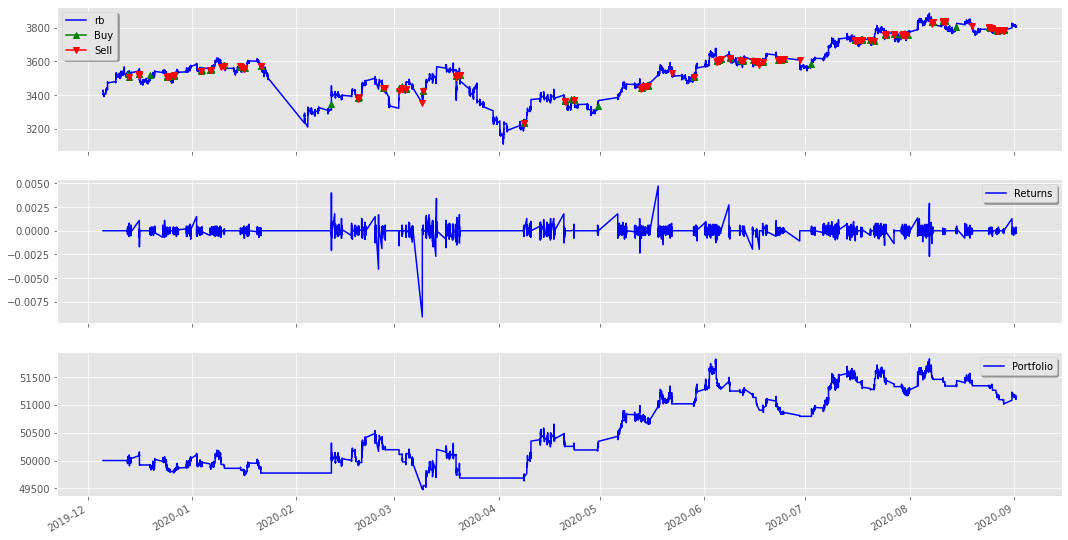

最终权益: 51120.00
累计回报率: 2.24%
夏普比率: -0.47
最大回撤率: 2.11%
最长回撤时间: 63 days, 5:05:00
总交易次数: 261
交易胜率：9.58%
利润, 均值 3.89, 标准差90.84, 最大值675.000000, 最小值-430.00
收益率, 均值 0.03%, 标准差0.53%, 最大值4.02%, 最小值-2.50%


In [9]:
myplt.plot()
totalTradeNums = tradeAnalyzer.getCount()
print(f'最终权益: {myStrategy.getResult():.2f}')
print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}')
print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')
print(f'总交易次数: {totalTradeNums}')
if totalTradeNums > 0:
    print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')

    profits = tradeAnalyzer.getAll()
    print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')

    returns = tradeAnalyzer.getAllReturns()
    print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')

## 策略例子

### 基于布林线的均值回归策略

- 当收盘价低于布林线下界的时候，**平空仓**，**建多仓**
- 当收盘价超过布林线上界的时候，**平多仓**，**建空仓**

#### 导入需要的包

In [10]:
from pyalgotrade import strategy, plotter
from pyalgotrade.technical import bollinger
from pyalgotrade.stratanalyzer import returns, sharpe, trades, drawdown
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency

#### 建立策略

In [11]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__positivePosition = None
        self.__negativePosition = None

    def getBollingerBands(self):
        return self.__bbands
    
    def onExitOk(self, position):
        order = position.getExitOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        if self.__negativePosition == position:
            self.__negativePosition = None
        elif self.__positivePosition == position:
            self.__positivePosition = None
        
    def onEnterOk(self, position):
        order = position.getEntryOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__negativePosition is not None and self.__negativePosition.exitActive() is False:
                # 有空仓，并且没有平空仓的挂单
                self.__negativePosition.exitMarket()
            if self.__positivePosition is None:
                # 没有多仓
                self.__positivePosition = self.enterLong(self.__instrument, 5)
        elif bar.getClose() > upper:
            if self.__positivePosition is not None and self.__positivePosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__positivePosition.exitMarket()
            if self.__negativePosition is None:
                # 没有空仓
                self.__negativePosition = self.enterShort(self.__instrument, 5)

#### 设定评估指标

In [12]:
def strategy_evaluation(inputStrategy):
    retAnalyzer = returns.Returns()
    sharpeAnalyzer = sharpe.SharpeRatio()
    ddAnalyzer = drawdown.DrawDown()
    tradesAnalyzer = trades.Trades()
    
    inputStrategy.attachAnalyzer(retAnalyzer)
    inputStrategy.attachAnalyzer(sharpeAnalyzer)
    inputStrategy.attachAnalyzer(ddAnalyzer)
    inputStrategy.attachAnalyzer(tradesAnalyzer)
    
    return retAnalyzer, sharpeAnalyzer, ddAnalyzer, tradesAnalyzer

#### 绘图

In [13]:
def strategy_plot(inputStrategy, instrument):
    strPlt = plotter.StrategyPlotter(inputStrategy)
    strPlt.getInstrumentSubplot(instrument).addDataSeries('upper',inputStrategy.getBollingerBands().getUpperBand())
    strPlt.getInstrumentSubplot(instrument).addDataSeries('lower',inputStrategy.getBollingerBands().getLowerBand())
    return strPlt

#### 读入数据

In [14]:
def read_data(instrument):
    strFeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
    strFeed.addBarsFromCSV(instrument,'./data/performance/rb.csv')
    return strFeed

#### 主函数

In [15]:
def main():
    instrument = 'rb'
    bBandsPeriod = 20
    numDev = 3
    feed = read_data(instrument)
    
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000)
    
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    stratPlt = strategy_plot(strat, instrument)
    
    strat.run()
    
    print(f'最终权益为：{strat.getResult()}')
    print(f'最终累积收益率为：{retEval.getCumulativeReturns()[-1]*100:.2f}%')
    print(f'Sharpe Ratio为：{sharpeEval.getSharpeRatio(0.03):.2f}')
    print(f'最大回撤为：{ddEval.getMaxDrawDown()*100:.2f}%')
    print(f'最长回撤时间为：{ddEval.getLongestDrawDownDuration()}')
    print(f'总交易次数为：{tradesEval.getCount()}')
    if tradesEval.getCount() > 0:
        print(f'胜率为：{tradesEval.getProfitableCount()/tradesEval.getCount()*100:.2f}%')
    
    stratPlt.savePlot('./img/performance/bbandsStrategy.png',dpi=300)

2019-12-05 14:54:00 strategy [INFO] 建多仓，价格为3411.00
2019-12-05 22:53:00 strategy [INFO] 平多仓，价格为3403.00
2019-12-05 22:53:00 strategy [INFO] 建空仓，价格为3403.00
2019-12-06 14:13:00 strategy [INFO] 平空仓，价格为3427.00
2019-12-06 14:13:00 strategy [INFO] 建多仓，价格为3427.00
2019-12-06 14:37:00 strategy [INFO] 平多仓，价格为3431.00
2019-12-06 14:37:00 strategy [INFO] 建空仓，价格为3431.00
2019-12-10 14:10:00 strategy [INFO] 平空仓，价格为3512.00
2019-12-10 14:10:00 strategy [INFO] 建多仓，价格为3512.00
2019-12-11 14:22:00 strategy [INFO] 平多仓，价格为3537.00
2019-12-11 14:22:00 strategy [INFO] 建空仓，价格为3537.00
2019-12-12 10:46:00 strategy [INFO] 平空仓，价格为3515.00
2019-12-12 10:46:00 strategy [INFO] 建多仓，价格为3515.00
2019-12-12 13:31:00 strategy [INFO] 平多仓，价格为3523.00
2019-12-12 13:31:00 strategy [INFO] 建空仓，价格为3523.00
2019-12-13 09:35:00 strategy [INFO] 平空仓，价格为3525.00
2019-12-13 09:35:00 strategy [INFO] 建多仓，价格为3525.00
2019-12-13 11:15:00 strategy [INFO] 平多仓，价格为3522.00
2019-12-13 11:15:00 strategy [INFO] 建空仓，价格为3522.00
2019-12-16 09:53:00 strategy [I

2020-04-07 14:41:00 strategy [INFO] 平多仓，价格为3213.00
2020-04-07 14:41:00 strategy [INFO] 建空仓，价格为3213.00
2020-04-08 09:01:00 strategy [INFO] 平空仓，价格为3195.00
2020-04-08 09:01:00 strategy [INFO] 建多仓，价格为3195.00
2020-04-08 14:41:00 strategy [INFO] 平多仓，价格为3244.00
2020-04-08 14:41:00 strategy [INFO] 建空仓，价格为3244.00
2020-04-10 11:27:00 strategy [INFO] 平空仓，价格为3320.00
2020-04-10 11:27:00 strategy [INFO] 建多仓，价格为3320.00
2020-04-10 14:32:00 strategy [INFO] 平多仓，价格为3339.00
2020-04-10 14:32:00 strategy [INFO] 建空仓，价格为3339.00
2020-04-14 09:52:00 strategy [INFO] 平空仓，价格为3384.00
2020-04-14 09:52:00 strategy [INFO] 建多仓，价格为3384.00
2020-04-17 09:00:00 strategy [INFO] 平多仓，价格为3399.00
2020-04-17 09:00:00 strategy [INFO] 建空仓，价格为3399.00
2020-04-17 10:45:00 strategy [INFO] 平空仓，价格为3391.00
2020-04-17 10:45:00 strategy [INFO] 建多仓，价格为3391.00
2020-04-20 09:00:00 strategy [INFO] 平多仓，价格为3400.00
2020-04-20 09:00:00 strategy [INFO] 建空仓，价格为3400.00
2020-04-20 14:35:00 strategy [INFO] 平空仓，价格为3361.00
2020-04-20 14:35:00 strategy [I

2020-07-20 14:41:00 strategy [INFO] 建空仓，价格为3710.00
2020-07-21 21:45:00 strategy [INFO] 平空仓，价格为3778.00
2020-07-21 21:45:00 strategy [INFO] 建多仓，价格为3778.00
2020-07-22 09:01:00 strategy [INFO] 平多仓，价格为3797.00
2020-07-22 09:01:00 strategy [INFO] 建空仓，价格为3797.00
2020-07-22 14:44:00 strategy [INFO] 平空仓，价格为3777.00
2020-07-22 14:44:00 strategy [INFO] 建多仓，价格为3777.00
2020-07-22 22:48:00 strategy [INFO] 平多仓，价格为3792.00
2020-07-22 22:48:00 strategy [INFO] 建空仓，价格为3792.00
2020-07-23 09:24:00 strategy [INFO] 平空仓，价格为3788.00
2020-07-23 09:24:00 strategy [INFO] 建多仓，价格为3788.00
2020-07-23 14:22:00 strategy [INFO] 平多仓，价格为3792.00
2020-07-23 14:22:00 strategy [INFO] 建空仓，价格为3792.00
2020-07-24 13:31:00 strategy [INFO] 平空仓，价格为3759.00
2020-07-24 13:31:00 strategy [INFO] 建多仓，价格为3759.00
2020-07-24 22:19:00 strategy [INFO] 平多仓，价格为3773.00
2020-07-24 22:19:00 strategy [INFO] 建空仓，价格为3773.00
2020-07-27 09:01:00 strategy [INFO] 平空仓，价格为3764.00
2020-07-27 09:01:00 strategy [INFO] 建多仓，价格为3764.00
2020-07-27 22:23:00 strategy [I

最终权益为：51300.0
最终累积收益率为：2.60%
Sharpe Ratio为：0.13
最大回撤为：3.85%
最长回撤时间为：195 days, 5:02:00
总交易次数为：208
胜率为：59.13%


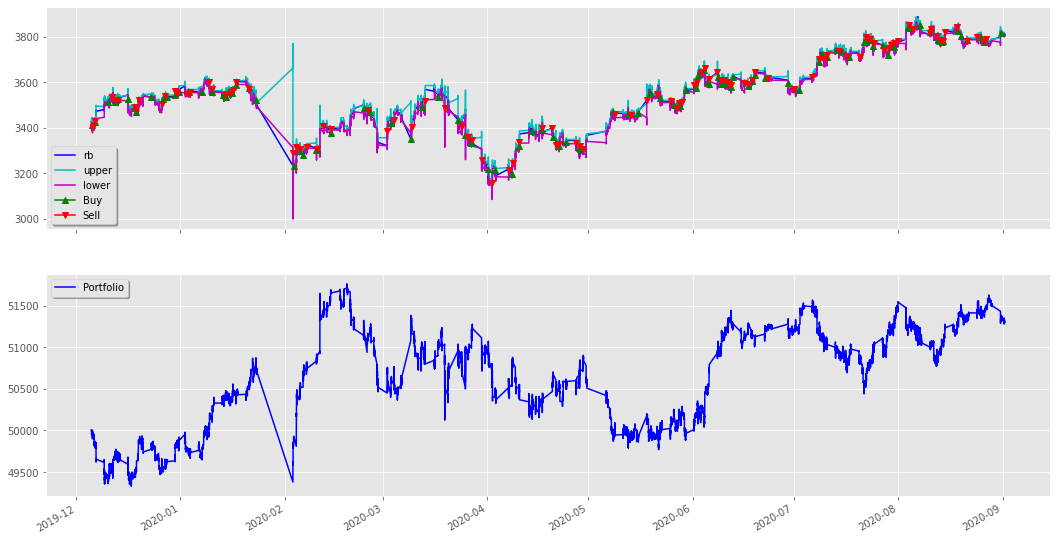

In [16]:
main()

### 配对套利策略

#### 导入需要的包

```python
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pyalgotrade import strategy
from pyalgotrade import dataseries
from pyalgotrade.dataseries import aligned
from pyalgotrade import plotter
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.stratanalyzer import sharpe
```

#### 建立策略

- 建立策略思路
    - 计算hedge ratio
    - 动态更新hedge ratio与正常范围
    - 识别交易机会

##### 计算hedge ratio

In [46]:
def get_beta(values1, values2):
    # 输入两个价格序列，values1作为被解释变量，values2作为解释变量
    model = sm.OLS(values1, values2)
    results = model.fit()
    return results.params[0]

##### 动态更新

In [47]:
class StatArbHelper:
    def __init__(self, ds1, ds2, windowSize):
        # 利用aligned对齐两个价格序列的时间
        self.__ds1, self.__ds2 = aligned.datetime_aligned(ds1, ds2)
        self.__windowSize = windowSize # 设定更新的时间窗口
        self.__hedgeRatio = None
        self.__spread = None          # 价格差
        self.__spreadMean = None
        self.__spreadStd = None
        self.__zScore = None          # 标准化后的价格差

    def getSpread(self):
        return self.__spread

    def getSpreadMean(self):
        return self.__spreadMean

    def getSpreadStd(self):
        return self.__spreadStd

    def getZScore(self):
        return self.__zScore

    def getHedgeRatio(self):
        return self.__hedgeRatio

    def __updateHedgeRatio(self, values1, values2):
        # 调用get_beta函数计算hedge ratio
        self.__hedgeRatio = get_beta(values1, values2)

    def __updateSpreadMeanAndStd(self, values1, values2):
        # 更新价格差序列的均值与标准差
        if self.__hedgeRatio is not None:
            spread = values1 - values2 * self.__hedgeRatio
            self.__spreadMean = spread.mean()
            self.__spreadStd = spread.std(ddof=1)

    def __updateSpread(self):
        # 计算最新的价格差
        if self.__hedgeRatio is not None:
            self.__spread = self.__ds1[-1] - self.__hedgeRatio * self.__ds2[-1]

    def __updateZScore(self):
        # 标准化最新的价格差
        if self.__spread is not None and self.__spreadMean is not None and self.__spreadStd is not None:
            self.__zScore = (self.__spread - self.__spreadMean) / float(self.__spreadStd)

    def update(self):
        # 更新相关变量
        if len(self.__ds1) >= self.__windowSize:
            values1 = np.asarray(self.__ds1[-1*self.__windowSize:])
            values2 = np.asarray(self.__ds2[-1*self.__windowSize:])
            self.__updateHedgeRatio(values1, values2)
            self.__updateSpread()
            self.__updateSpreadMeanAndStd(values1, values2)
            self.__updateZScore()

```python
pyalgotrade.dataseries.aligned.datetime_aligned(ds1,ds2)
```
- 生成两个价格序列都包含相同时间点的部分

##### 识别套利机会

In [82]:
class StatArb(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument1, instrument2, windowSize):
        super(StatArb, self).__init__(feed,50000)
        self.__statArbHelper = StatArbHelper(feed[instrument1].getCloseDataSeries(), feed[instrument2].getCloseDataSeries(), windowSize)
        self.__i1 = instrument1
        self.__i2 = instrument2

        # These are used only for plotting purposes.
        self.__spread = dataseries.SequenceDataSeries()
        self.__hedgeRatio = dataseries.SequenceDataSeries()

    def getSpreadDS(self):
        return self.__spread

    def getHedgeRatioDS(self):
        return self.__hedgeRatio

    def __getOrderSize(self, bars, hedgeRatio):
        # 计算下单数量
        cash = self.getBroker().getCash(False)
        price1 = bars[self.__i1].getClose()
        price2 = bars[self.__i2].getClose()
        size1 = int(cash / (price1 + hedgeRatio * price2))
        size2 = int(size1 * hedgeRatio)
        return (size1, size2)

    def buySpread(self, bars, hedgeRatio):
        # 买基差
        amount1, amount2 = self.__getOrderSize(bars, hedgeRatio)
        self.enterLong(self.__i1, amount1)
        self.enterShort(self.__i2, amount2)

    def sellSpread(self, bars, hedgeRatio):
        # 卖基差
        amount1, amount2 = self.__getOrderSize(bars, hedgeRatio)
        self.enterShort(self.__i1, amount1)
        self.enterLong(self.__i2, amount2)

    def reducePosition(self, instrument):
        # 平仓
        currentPos = self.getBroker().getShares(instrument)
        if currentPos > 0:
            self.marketOrder(instrument, currentPos * -1)
        elif currentPos < 0:
            self.marketOrder(instrument, currentPos * -1)

    def onBars(self, bars):
        self.__statArbHelper.update()

        # These is used only for plotting purposes.
        self.__spread.appendWithDateTime(bars.getDateTime(), self.__statArbHelper.getSpread())
        self.__hedgeRatio.appendWithDateTime(bars.getDateTime(), self.__statArbHelper.getHedgeRatio())

        if bars.getBar(self.__i1) and bars.getBar(self.__i2):
            hedgeRatio = self.__statArbHelper.getHedgeRatio()
            zScore = self.__statArbHelper.getZScore()
            if zScore is not None:
                currentPos = abs(self.getBroker().getShares(self.__i1)) + abs(self.getBroker().getShares(self.__i2))
                if abs(zScore) <= 1 and currentPos != 0:
                    # 进入正常范围内，平仓
                    self.reducePosition(self.__i1)
                    self.reducePosition(self.__i2)
                elif zScore <= -2 and currentPos == 0:  # 当基差跌破下届，买基差
                    self.buySpread(bars, hedgeRatio)
                elif zScore >= 2 and currentPos == 0:  # 当基差涨破上届，卖基差
                    self.sellSpread(bars, hedgeRatio)

#### 主函数

In [85]:
def pair_main():
    instruments = ['j','zc']
    windowSize = 50
    feed = csvfeed.GenericBarFeed(Frequency.DAY)
    for each in instruments:
        fileName = f'./data/performance/{each}continuous_eng.csv'
        print(fileName)
        feed.addBarsFromCSV(each,fileName)
    strat = StatArb(feed,instruments[0],instruments[1],windowSize)
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    plt = plotter.StrategyPlotter(strat, False, False, True)
    plt.getOrCreateSubplot("hedge").addDataSeries("Hedge Ratio", strat.getHedgeRatioDS())
    plt.getOrCreateSubplot("spread").addDataSeries("Spread", strat.getSpreadDS())

    
    strat.run()
    
    print(f'最终权益为：{strat.getResult()}')
    print(f'最终累积收益率为：{retEval.getCumulativeReturns()[-1]*100:.2f}%')
    print(f'Sharpe Ratio为：{sharpeEval.getSharpeRatio(0.03):.2f}')
    print(f'最大回撤为：{ddEval.getMaxDrawDown()*100:.2f}%')
    print(f'最长回撤时间为：{ddEval.getLongestDrawDownDuration()}')
    print(f'总交易次数为：{tradesEval.getCount()}')
    if tradesEval.getCount() > 0:
        print(f'胜率为：{tradesEval.getProfitableCount()/tradesEval.getCount()*100:.2f}%')
    plt.plot()
    

#### 回测策略

./data/performance/jcontinuous_eng.csv
./data/performance/zccontinuous_eng.csv
最终权益为：57504.59999999999
最终累积收益率为：15.01%
Sharpe Ratio为：-0.11
最大回撤为：22.49%
最长回撤时间为：1418 days, 0:00:00
总交易次数为：70
胜率为：60.00%


<IPython.core.display.Javascript object>


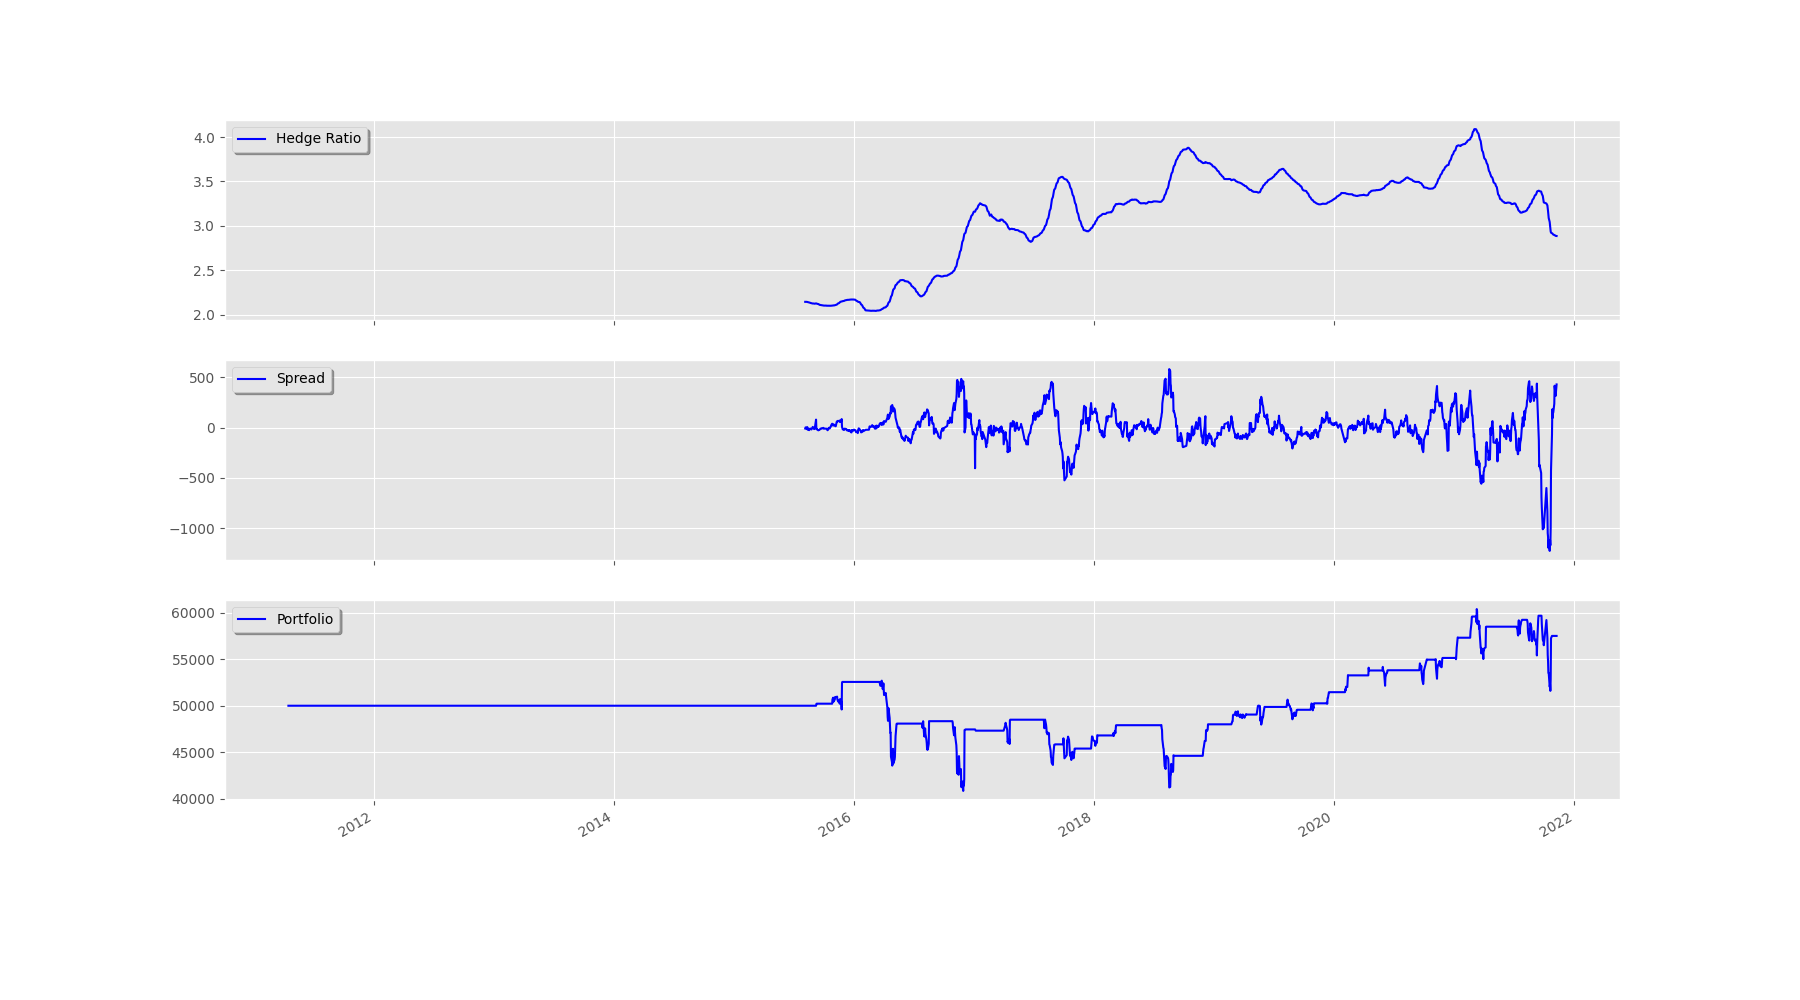

In [86]:
pair_main()

## 模型优化

- 量化模型优化的两个着手点
    - 样本数据的选择
    - 模型参数的选择

### 样本数据选择

- 样本数据的回测效果受到两个方面的影响
    - 宏观层面：周期性波动
    - 微观层面：数据波动性的变化

#### 周期性波动

<center><img src="./img/performance/cycleTheory.jpg" width=100%></center>

<center><img src="./img/performance/cycles.png" width=100%></center>

<center><img src="./img/performance/cu.PNG" width=100%></center>

- 铜（cu）期货的周线数据

#### 波动性变化

- 股指期货保证金、手续费增加的影响

<center><img src="./img/performance/ifMargin.jpg" width=100%></center>

<center><img src="./img/performance/if.PNG" width=100%></center>

#### 样本内外数据的划分

- 历史基准法
    - 将距离当前较远的数据作为样本内数据，进行回测，再利用距离当前较近的数据检验

- 当前基准法
    - 将距离当前最近的一段数据作为样本内数据，进行回测，再利用距离当前较远的数据检验

- 中间基准法
    - 利用中间段的数据进行回测，再利用两端的数据检验

### 最优参数选择

- 直接优化法
    - 设定目标函数
    - 设定参数取值范围**组合**

#### 参数的搜索空间

- 例如：基于布林线的均值回归策略

- 两个参数，布林线上下界时间窗口、中线离上下界的距离（标准差的倍数）

In [17]:
paraTup = []
for each in range(20,70,5):
    for num in np.linspace(0.5,4,8):
        paraTup.append((each,num))
print(paraTup)

[(20, 0.5), (20, 1.0), (20, 1.5), (20, 2.0), (20, 2.5), (20, 3.0), (20, 3.5), (20, 4.0), (25, 0.5), (25, 1.0), (25, 1.5), (25, 2.0), (25, 2.5), (25, 3.0), (25, 3.5), (25, 4.0), (30, 0.5), (30, 1.0), (30, 1.5), (30, 2.0), (30, 2.5), (30, 3.0), (30, 3.5), (30, 4.0), (35, 0.5), (35, 1.0), (35, 1.5), (35, 2.0), (35, 2.5), (35, 3.0), (35, 3.5), (35, 4.0), (40, 0.5), (40, 1.0), (40, 1.5), (40, 2.0), (40, 2.5), (40, 3.0), (40, 3.5), (40, 4.0), (45, 0.5), (45, 1.0), (45, 1.5), (45, 2.0), (45, 2.5), (45, 3.0), (45, 3.5), (45, 4.0), (50, 0.5), (50, 1.0), (50, 1.5), (50, 2.0), (50, 2.5), (50, 3.0), (50, 3.5), (50, 4.0), (55, 0.5), (55, 1.0), (55, 1.5), (55, 2.0), (55, 2.5), (55, 3.0), (55, 3.5), (55, 4.0), (60, 0.5), (60, 1.0), (60, 1.5), (60, 2.0), (60, 2.5), (60, 3.0), (60, 3.5), (60, 4.0), (65, 0.5), (65, 1.0), (65, 1.5), (65, 2.0), (65, 2.5), (65, 3.0), (65, 3.5), (65, 4.0)]


#### 优化策略参数

In [18]:
def main(bBandsPeriod, numDev):
    instrument = 'rb'
    feed = read_data(instrument)
    
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000)
    
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    stratPlt = strategy_plot(strat, instrument)
    
    strat.run()
    
    sharpe = sharpeEval.getSharpeRatio(0.03)
    print(f'Sharpe Ratio为：{sharpe}')
    return sharpe

In [19]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__positivePosition = None
        self.__negativePosition = None

    def getBollingerBands(self):
        return self.__bbands
    
    def onExitOk(self, position):
#         order = position.getExitOrder()
#         execInfo = order.getExecutionInfo()
#         self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        if self.__negativePosition == position:
            self.__negativePosition = None
        elif self.__positivePosition == position:
            self.__positivePosition = None
        
#     def onEnterOk(self, position):
#         order = position.getEntryOrder()
#         execInfo = order.getExecutionInfo()
#         self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__negativePosition is not None and self.__negativePosition.exitActive() is False:
                # 有空仓，并且没有平空仓的挂单
                self.__negativePosition.exitMarket()
            if self.__positivePosition is None:
                # 没有多仓
                self.__positivePosition = self.enterLong(self.__instrument, 5)
        elif bar.getClose() > upper:
            if self.__positivePosition is not None and self.__positivePosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__positivePosition.exitMarket()
            if self.__negativePosition is None:
                # 没有空仓
                self.__negativePosition = self.enterShort(self.__instrument, 5)

In [22]:
%%time
resLst = []
for period, num in paraTup:
    resLst.append(main(period,num))

Sharpe Ratio为：2.2108375379817136
Sharpe Ratio为：0.23014163745987642
Sharpe Ratio为：0.0601307076066334
Sharpe Ratio为：2.3831086230801923
Sharpe Ratio为：1.3065758045980598
Sharpe Ratio为：0.1317123033445212
Sharpe Ratio为：0.1459775249238472
Sharpe Ratio为：0.4831753455835114
Sharpe Ratio为：1.1839954520962772
Sharpe Ratio为：-0.1836059468433718
Sharpe Ratio为：0.8154530206953502
Sharpe Ratio为：2.086549705863651
Sharpe Ratio为：0.2328843341226429
Sharpe Ratio为：0.7399482044921095
Sharpe Ratio为：0.08910461625292304
Sharpe Ratio为：-0.6895469555136364
Sharpe Ratio为：0.8577280900937782
Sharpe Ratio为：-0.6730735417233424
Sharpe Ratio为：1.4090223753077256
Sharpe Ratio为：1.0548175119022398
Sharpe Ratio为：-0.4483849687969193
Sharpe Ratio为：-0.44745629541271964
Sharpe Ratio为：-1.1789777731610196
Sharpe Ratio为：0.2775991474702872
Sharpe Ratio为：0.734375822222705
Sharpe Ratio为：0.18922114493306816
Sharpe Ratio为：1.7763306473972404
Sharpe Ratio为：1.280510082046601
Sharpe Ratio为：-0.13373836504003553
Sharpe Ratio为：0.8314550203336103
S

#### 利用优化模块

##### 利用itertools生成参数空间

```python
import itertools
itertools.product(*iterables, repeat=1)
```
- 计算输入的可迭代对象的笛卡尔乘积

In [30]:
instruments = ['rb']
bbPeriods = range(20,70,5)
numDevs = np.linspace(0.5,4,8)
initCap = [50000]
paraTup2 = itertools.product(instruments,bbPeriods,numDevs,initCap)
paraTup2

##### 并行运算

```python
from pyalgotrade.optimizer import local
local.run(strategyClass,barFeed,strategyParameters,workerCount=None)
# 在本机并行运算找到最优参数
```
- `strategyClass`：自定义的策略类
- `barFeed`：创建的数据源对象
- `strategyParameters`：参数组合
- `workerCount`：并行运行的策略数量，`None`表明与CPU的核数量一致

In [32]:
%%time
feed = read_data(instruments[0])
local.run(myBBands,feed,paraTup2)

2021-11-17 23:06:49,308 pyalgotrade.optimizer.local [INFO] Starting server on port 48235
2021-11-17 23:06:49,311 pyalgotrade.optimizer.xmlrpcserver [INFO] Loading bars
2021-11-17 23:06:49,312 pyalgotrade.optimizer.local [INFO] Waiting for the server to be ready
2021-11-17 23:06:52,554 pyalgotrade.optimizer.xmlrpcserver [INFO] Started serving
2021-11-17 23:06:52,555 pyalgotrade.optimizer.local [INFO] Starting 2 workers
2021-11-17 23:17:19,826 pyalgotrade.optimizer.xmlrpcserver [INFO] Best result so far 57005.0 with parameters ('rb', 20, 2.0, 50000)
2021-11-17 23:17:20,229 pyalgotrade.optimizer.local [INFO] Stopping server
2021-11-17 23:17:20,330 pyalgotrade.optimizer.xmlrpcserver [INFO] Finished serving


CPU times: user 5.44 s, sys: 128 ms, total: 5.57 s
Wall time: 10min 32s


#### 可视化展示参数空间对应的结果

<IPython.core.display.Javascript object>


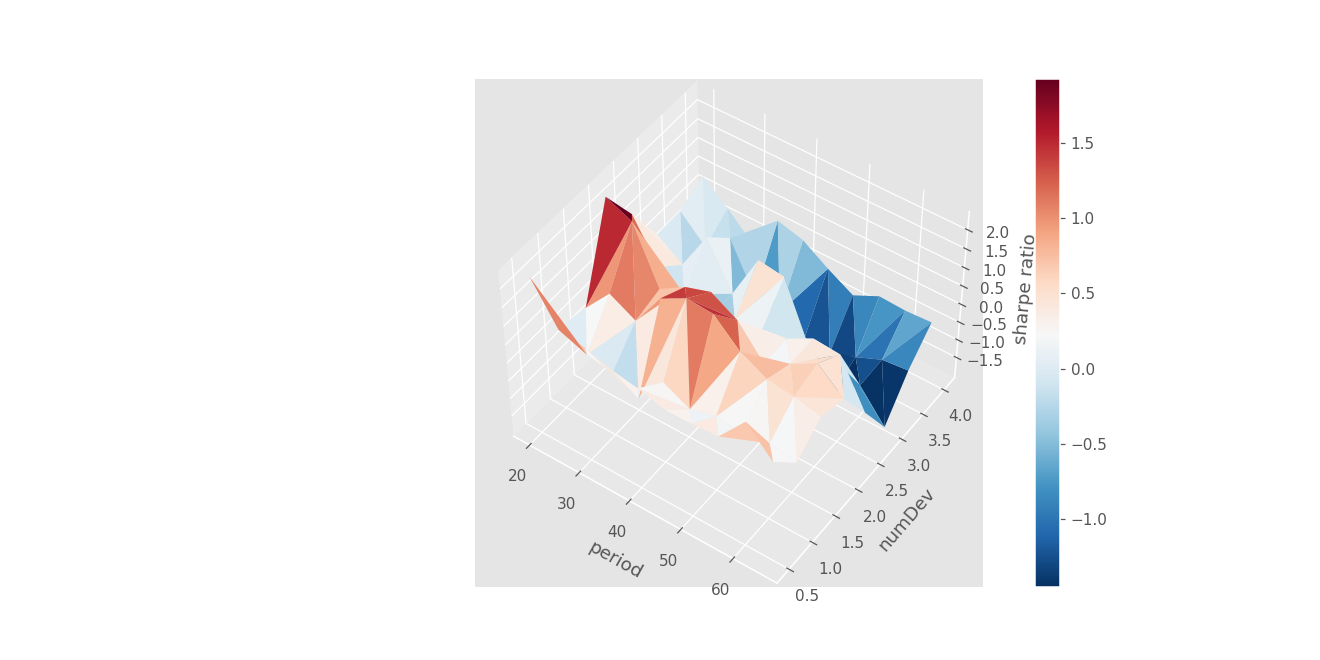

[Text(0.5, 0, 'period'), Text(0.5, 0, 'numDev'), Text(0.5, 0, 'sharpe ratio')]

In [24]:
%matplotlib notebook
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1, projection='3d')
x = [each[0] for each in paraTup]
y = [each[1] for each in paraTup]
triag = mtri.Triangulation(x,y)
surf = ax.plot_trisurf(triag,resLst,cmap="RdBu_r")
ax.set(xlabel='period',ylabel='numDev',zlabel='sharpe ratio')
fig.colorbar(surf,ax=ax)

#### 选什么样的参数？

- 一个策略的目标函数值随着参数取值的变化

<center><img src="./img/performance/plateau.PNG" width=100%></center>

- 选择B点作为最优参数

- B点位于参数**高原**(plateau)的中心，参数的可靠性高

- D点是一个参数**孤岛**，可能是过度拟合导致的